# Multisensor fusion project
- Experiment data: June 2022. Maraging Steel 300
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature, thermal features
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 1: Vision acoustic dataset segmentation

In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2
from IPython.display import Image, display

In [20]:
import scaleogram as scg 
from glob import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import glob
import re
from tqdm import tqdm
import numpy as np
import torch
from PIL import Image

In [3]:
# ------------------- plotly visualizatoin----------------------------------
# from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [4]:
## Audio signal processing libraries
import librosa
import librosa.display

import IPython.display as ipd
import plotly.express as px
import plotly.io as pio
# import nussl
import natsort

In [5]:
from moviepy.editor import VideoFileClip

In [29]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"

Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

Video_path = os.path.join(Multimodal_dataset_PATH, 'Video')

IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'pre-processing')

os.makedirs(IMAGE_PATH, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [8]:
def simple_visualization(sound, sr=44100, alpha = 1, fig_size = (10,2)):
    fig, axs = plt.subplots(1, 1, tight_layout = True, figsize=fig_size) #constrained_layout=True,

    librosa.display.waveplot(sound, sr=sr, alpha=alpha, label = 'original signal')
    axs.set_xlabel('Time [sec]', fontsize = 14)
    axs.set_ylabel('Amplitute', fontsize = 14)
    # axs.set_ylim([-0.28, 0.28])
    # axs.set_yticks([-0.25, 0, 0.25])

    # fig.suptitle("Time-domain visualisation", fontsize = 16)
    
def plot_spectrogram(spec, title=None, ylabel='Frequency bins', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
        fig.colorbar(im, ax=axs)
    # plt.show(block=False)

In [7]:
sys.path.insert(0, 'utils')

import visualization

# Segment MP4 video file

- __FFmpeg__:  extract the audio stream from the input MP4 file (__not recommended__) --> result in corrupted file
- __moviepy__: extract audio from mp4 video stream.
- __OpenCV__: extract the video frames
- __iterates over each frame__ and uses FFmpeg to extract the corresponding audio segment; OpenCV to extract the corresponding video segment
- The audio and image segments are then saved to their respective output folders with the desired names.

## Single file segmentation

In [41]:
sample_index = 24

# ----------------Define input video file path---------------
raw_video_file = os.path.join(Video_path, str(sample_index), 'raw',  f'{sample_index}-raw.mp4')
equalized_video_file = os.path.join(Video_path, str(sample_index), 'equalized', f'{sample_index}-equalized.mp4') 
bandpassed_video_file = os.path.join(Video_path, str(sample_index), 'bandpassed', f'{sample_index}-bandpassed.mp4') 
denoised_video_file = os.path.join(Video_path, str(sample_index), 'denoised', f'{sample_index}-denoised.mp4') 


# Output folders
raw_audio_output_folder = os.path.join(Multimodal_dataset_PATH,  '25Hz', str(sample_index), 'raw_audio')
equalized_audio_output_folder = os.path.join(Multimodal_dataset_PATH,  '25Hz', str(sample_index),'equalized_audio')
bandpassed_audio_output_folder = os.path.join(Multimodal_dataset_PATH, '25Hz',str(sample_index), 'bandpassed_audio')
denoised_audio_output_folder = os.path.join(Multimodal_dataset_PATH, '25Hz',str(sample_index), 'denoised_audio')
image_output_folder = os.path.join(Multimodal_dataset_PATH, '25Hz',str(sample_index), 'images')


# Create output folders if they don't exist
if not os.path.exists(image_output_folder):
    os.makedirs(image_output_folder)
if not os.path.exists(denoised_audio_output_folder):
    os.makedirs(denoised_audio_output_folder)
if not os.path.exists(raw_audio_output_folder):
    os.makedirs(raw_audio_output_folder)
if not os.path.exists(equalized_audio_output_folder):
    os.makedirs(equalized_audio_output_folder)
if not os.path.exists(bandpassed_audio_output_folder):
    os.makedirs(bandpassed_audio_output_folder)

In [10]:
### ------------------Extract audio (wav) from video (MP4) ------------------
### ---------For single video file -----------
# Extract the audio
audio = VideoFileClip(raw_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/combined/raw.wav')

# Extract the audio
audio = VideoFileClip(equalized_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/combined/equalized.wav')

# Extract the audio
audio = VideoFileClip(bandpassed_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/combined/bandpassed.wav')

# Extract the audio
audio = VideoFileClip(denoised_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/combined/denoised.wav')

MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/combined/raw.wav


MoviePy - Done.
MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/combined/equalized.wav


MoviePy - Done.
MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/combined/bandpassed.wav


MoviePy - Done.
MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/combined/denoised.wav


MoviePy - Done.


### Testing for single a single video file

In [42]:
### -----------------For single video file ---------------
# Load the audio and calculate the segment length in samples
y_raw, sr = librosa.load(f'{Video_path}/{sample_index}/audio/raw.wav', sr=None)
y_equalized, sr = librosa.load(f'{Video_path}/{sample_index}/audio/equalized.wav', sr=None)
y_bandpassed, sr = librosa.load(f'{Video_path}/{sample_index}/audio/bandpassed.wav', sr=None)
y_denoised, sr = librosa.load(f'{Video_path}/{sample_index}/audio/denoised.wav', sr=None)

segment_duration = 0.04  # 0.04 seconds. 25 Hz
segment_length = int(segment_duration * sr)
print ("the segmentation sample length is: " + str(segment_length))
print ("the segmentation length in second is: " + str(segment_length/44100))
print ("total duration of audio signal: " + str(len(y_raw)/44100))
print ("total number of images: " + str((len(y_raw) - segment_length)/segment_length))
print ("length of each audio file are: " + str(len(y_denoised)/44100) + "; " + str(len(y_raw)/44100) + "; " + str(len(y_equalized)/44100) 
       + "; " + str(len(y_bandpassed)/44100))

the segmentation sample length is: 1764
the segmentation length in second is: 0.04
total duration of audio signal: 676.03
total number of images: 16899.75
length of each audio file are: 652.69; 676.03; 675.99; 675.97


In [43]:
sr

44100

In [44]:
len(y_denoised) - segment_length

28781865

In [45]:
segment_length

1764

### Method 1: direct segmentation
- No past data was used
- Only the current time frame

In [46]:
# Initialize a counter for audio and image file names
counter = 1
segment_length_samples = int(0.04 * sr)  # 40ms corresponds to 0.04 seconds, 25 Hz
raw_seg = []
equalized_seg = []
bandpassed_seg = []
denoised_seg = []

# Initialize video capture once before the loop
cap = cv2.VideoCapture(denoised_video_file)
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculate total iterations for tqdm
total_iterations = (len(y_denoised) - segment_length_samples) // segment_length_samples

# Iterate over the audio and save each segment
for i in tqdm(range(0, len(y_denoised) - segment_length_samples, segment_length_samples), total=total_iterations):
    # print (i)
    # Extract the audio segment
    segment_denoised = y_denoised[i:i+segment_length]
    segment_raw = y_raw[i:i+segment_length]
    segment_equalized = y_equalized[i:i+segment_length]
    segment_bandpassed = y_bandpassed[i:i+segment_length]
    
    denoised_seg.append(segment_denoised)
    raw_seg.append(segment_raw)
    equalized_seg.append(segment_equalized)
    bandpassed_seg.append(segment_bandpassed)
    
    sf.write(f'{raw_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_raw, samplerate = sr)
    sf.write(f'{equalized_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_equalized, samplerate = sr)
    sf.write(f'{bandpassed_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_bandpassed, samplerate = sr)
    sf.write(f'{denoised_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_denoised, samplerate = sr)

    
    # Use OpenCV to extract the video segment
    frame_index = round(i / sr * fps)  # Rounding might give a closer frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if ret:  # Check if frame read successfully
        cv2.imwrite(f'{image_output_folder}/sample_{sample_index}_{counter}.jpg', frame)
    else:
        print(f"Failed to read frame for counter: {counter}")
    
    # Increment the counter
    counter += 1

cap.release()

16317it [42:42,  6.37it/s]                                                                                                                                                                                 


### Method 2: buffered segmentation
- Selected approach
- Include 60 ms from the past time stamp
- Include 40 ms from the current time stamp

In [15]:
# Initialize a counter for audio and image file names
counter = 1
segment_length_samples = int(0.04 * sr)  # 40ms corresponds to 0.04 seconds, 25 Hz
raw_seg = []
equalized_seg = []
bandpassed_seg = []
denoised_seg = []

# Initialize video capture once before the loop
cap = cv2.VideoCapture(denoised_video_file)
fps = cap.get(cv2.CAP_PROP_FPS)

# Calculate total iterations for tqdm
total_iterations = (len(y_denoised) - segment_length_samples) // segment_length_samples


# Iterate over the audio and save each segment
# for i in range(0, len(y_denoised) - segment_length_samples, segment_length_samples):
# Iterate over the audio and save each segment with progress bar
for i in tqdm(range(0, len(y_denoised) - segment_length_samples, segment_length_samples), total=total_iterations):
 
    # Calculate the start and end indices for the 100 ms audio segment
    start_index = max(0, i - int(0.06 * sr))  # Include 80 ms from the past timestamp. it will be zero for all initial frames
    end_index = i + segment_length_samples  # Include 20 ms from the current time stamp
    
    # Padding for initial segments
    pad_size = abs(start_index - (i - int(0.06 * sr)))  # Calculate padding size

    # Extract the audio segment
    # Extract the audio segment and pad if necessary
    segment_denoised = np.pad(y_denoised[start_index:end_index], (pad_size, 0), 'constant')
    segment_raw = np.pad(y_raw[start_index:end_index], (pad_size, 0), 'constant')
    segment_equalized = np.pad(y_equalized[start_index:end_index], (pad_size, 0), 'constant')
    segment_bandpassed = np.pad(y_bandpassed[start_index:end_index], (pad_size, 0), 'constant')
    
    # Save the audio segments
    sf.write(f'{raw_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_raw, samplerate=sr)
    sf.write(f'{equalized_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_equalized, samplerate=sr)
    sf.write(f'{bandpassed_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_bandpassed, samplerate=sr)
    sf.write(f'{denoised_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_denoised, samplerate=sr)


    denoised_seg.append(segment_denoised)
    raw_seg.append(segment_raw)
    equalized_seg.append(segment_equalized)
    bandpassed_seg.append(segment_bandpassed)


    # Use OpenCV to extract the video segment
    frame_index = round(i / sr * fps)  # Rounding might give a closer frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if ret:  # Check if frame read successfully
        cv2.imwrite(f'{image_output_folder}/sample_{sample_index}_{counter}.jpg', frame)
    else:
        print(f"Failed to read frame for counter: {counter}")

    # Increment the counter
    counter += 1
    
cap.release()


16317it [43:45,  6.21it/s]                                                                                                                                                                                 


In [50]:
# show list of stored variables
%store

Stored variables and their in-db values:
bandpassed_seg                  -> [array([ 0.        ,  0.        ,  0.        , ...
bandpassed_seg_list             -> [[array([ 0.        ,  0.        ,  0.        , ..
denoised_seg                    -> [array([0.        , 0.        , 0.        , ..., 0
denoised_seg_list               -> [[array([ 0.        ,  0.        ,  0.        , ..
equalized_seg                   -> [array([ 0.        ,  0.        ,  0.        , ...
equalized_seg_list              -> [[array([ 0.        ,  0.        ,  0.        , ..
raw_seg                         -> [array([0.        , 0.        , 0.        , ..., 0
raw_seg_list                    -> [[array([ 0.        ,  0.        ,  0.        , ..


In [ ]:
## store the variables
%store raw_seg
%store equalized_seg
%store bandpassed_seg
%store denoised_seg

Stored 'raw_seg' (list)
Stored 'equalized_seg' (list)
Stored 'bandpassed_seg' (list)
Stored 'denoised_seg' (list)


In [13]:
## load the variables
%store -r raw_seg
%store -r equalized_seg
%store -r bandpassed_seg
%store -r denoised_seg

## Multiple video file segmentation (for 24)

In [ ]:
sample_index = 24

raw_video_file_list = []
equalized_video_file_list = []
bandpassed_video_file_list = []
denoised_video_file_list = []
for i in range(57,61):
    print (i)
    raw_video_file_list.append(os.path.join(Video_path, str(sample_index), 'raw',  f'{sample_index}-layer{i}-raw.mp4'))
    equalized_video_file_list.append(os.path.join(Video_path, str(sample_index), 'equalized', f'{sample_index}-layer{i}-equalized.mp4'))
    bandpassed_video_file_list.append(os.path.join(Video_path, str(sample_index), 'bandpassed', f'{sample_index}-layer{i}-bandpassed.mp4'))
    denoised_video_file_list.append(os.path.join(Video_path, str(sample_index), 'denoised', f'{sample_index}-layer{i}-denoised.mp4'))

# Output folders
raw_audio_output_folder = os.path.join(Video_path,  'segmented', 'raw_audio')
equalized_audio_output_folder = os.path.join(Video_path,  'segmented','equalized_audio')
bandpassed_audio_output_folder = os.path.join(Video_path, 'segmented', 'bandpassed_audio')
denoised_audio_output_folder = os.path.join(Video_path, 'segmented', 'denoised_audio')
image_output_folder = os.path.join(Video_path, 'segmented', 'images')


# Create output folders if they don't exist
if not os.path.exists(image_output_folder):
    os.makedirs(image_output_folder)
if not os.path.exists(denoised_audio_output_folder):
    os.makedirs(denoised_audio_output_folder)
if not os.path.exists(raw_audio_output_folder):
    os.makedirs(raw_audio_output_folder)
if not os.path.exists(equalized_audio_output_folder):
    os.makedirs(equalized_audio_output_folder)
if not os.path.exists(bandpassed_audio_output_folder):
    os.makedirs(bandpassed_audio_output_folder)

In [19]:
### ---------For multiple video file: extraction at once-----------
# Extract the audio
for counter, i in enumerate(range(57,61)):    
    audio_raw = VideoFileClip(raw_video_file_list[counter]).audio
    audio_raw.write_audiofile(f'{Video_path}/{sample_index}/audio/layer{i}-raw.wav')
    
    audio_equalized = VideoFileClip(equalized_video_file_list[counter]).audio
    audio_equalized.write_audiofile(f'{Video_path}/{sample_index}/audio/layer{i}-equalzied.wav')
    
    audio_bandpassed = VideoFileClip(bandpassed_video_file_list[counter]).audio
    audio_bandpassed.write_audiofile(f'{Video_path}/{sample_index}/audio/layer{i}-bandpassed.wav')
    
    audio_denoised = VideoFileClip(denoised_video_file_list[counter]).audio
    audio_denoised.write_audiofile(f'{Video_path}/{sample_index}/audio/layer{i}-denoised.wav')

MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer57-raw.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer57-equalzied.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer57-bandpassed.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer57-denoised.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer58-raw.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer58-equalzied.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer58-bandpassed.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer58-denoised.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer59-raw.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer59-equalzied.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer59-bandpassed.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer59-denoised.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer60-raw.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer60-equalzied.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer60-bandpassed.wav


MoviePy - Done.


MoviePy - Writing audio in /home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/Video/24/audio/layer60-denoised.wav


MoviePy - Done.


In [22]:
### ---------For multiple video file: extraction at once----------

y_raw_list = []
y_equalized_list = []
y_bandpassed_list = []
y_denoised_list = []

segment_duration = 0.1  # 0.1 seconds
segment_length = int(segment_duration * sr)

for counter, i in enumerate(range(57,61)):    
    y_raw_list.append(librosa.load(f'{Video_path}/{sample_index}/audio/layer{i}-raw.wav', sr=None)[0])
    y_equalized_list.append(librosa.load(f'{Video_path}/{sample_index}/audio/layer{i}-equalzied.wav', sr=None)[0])
    y_bandpassed_list.append(librosa.load(f'{Video_path}/{sample_index}/audio/layer{i}-bandpassed.wav', sr=None)[0])
    y_denoised_list.append(librosa.load(f'{Video_path}/{sample_index}/audio/layer{i}-denoised.wav', sr=None)[0])
    print (f"layer: {i}")
    print ("total duration of audio signal: " + str(len(y_raw_list[counter])/44100))
    print ("total number of images: " + str(int((len(y_raw_list[counter]) - segment_length)/segment_length)))
    print ("length of each audio file are: " + str(len(y_denoised_list[counter])/44100) + "; " + str(len(y_raw_list[counter])/44100) +
           "; " + str(len(y_equalized_list[counter])/44100) 
            + "; " + str(len(y_bandpassed_list[counter])/44100))

layer: 57
total duration of audio signal: 3.63
total number of images: 35
length of each audio file are: 3.63; 3.63; 3.63; 3.63
layer: 58
total duration of audio signal: 3.63
total number of images: 35
length of each audio file are: 3.63; 3.63; 3.63; 3.63
layer: 59
total duration of audio signal: 3.56
total number of images: 34
length of each audio file are: 3.56; 3.56; 3.56; 3.56
layer: 60
total duration of audio signal: 3.63
total number of images: 35
length of each audio file are: 3.63; 3.63; 3.63; 3.63


In [24]:
print ("total duration of audio signal: " + str(len(y_raw_list[2])/44100))

total duration of audio signal: 3.56


In [27]:
raw_seg_list = []
equalized_seg_list = []
bandpassed_seg_list = []
denoised_seg_list = []

for counter, layer_number in enumerate(range(57,61)): 
    print (f"layer number: {layer_number}")
    print (f"counter: {counter}")
    raw_seg = []
    equalized_seg = []
    bandpassed_seg = []
    denoised_seg = []
    
    file_index = 1

    # Iterate over each audio file and save each 0.1s segment
    for i in range(0, len(y_raw_list[counter]) - segment_length, segment_length):
        # Extract the audio segment
        segment_raw = y_raw_list[counter][i:i+segment_length]
        segment_equalized = y_equalized_list[counter][i:i+segment_length]
        segment_bandpassed = y_bandpassed_list[counter][i:i+segment_length]
        segment_denoised = y_denoised_list[counter][i:i+segment_length]

        raw_seg.append(segment_raw)
        equalized_seg.append(segment_equalized)
        bandpassed_seg.append(segment_bandpassed)
        denoised_seg.append(segment_denoised)
        
        sf.write(f'{raw_audio_output_folder}/sample_{sample_index}_layer_{layer_number}_{file_index}.wav', segment_raw, samplerate = sr)
        sf.write(f'{equalized_audio_output_folder}/sample_{sample_index}_layer_{layer_number}_{file_index}.wav', segment_equalized, samplerate = sr)
        sf.write(f'{bandpassed_audio_output_folder}/sample_{sample_index}_layer_{layer_number}_{file_index}.wav', segment_bandpassed, samplerate = sr)
        sf.write(f'{denoised_audio_output_folder}/sample_{sample_index}_layer_{layer_number}_{file_index}.wav', segment_denoised, samplerate = sr)

        # Use OpenCV to extract the video segment
        cap = cv2.VideoCapture(denoised_video_file_list[counter])
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(i / sr * fps))
        ret, frame = cap.read()
        cv2.imwrite(f'{image_output_folder}/sample_{sample_index}_layer_{layer_number}_{file_index}.jpg', frame)
        cap.release()
        
        file_index +=1
        
    cap.release()
    
    raw_seg_list.append(raw_seg)
    equalized_seg_list.append(equalized_seg)
    bandpassed_seg_list.append(bandpassed_seg)
    denoised_seg_list.append(denoised_seg)

layer number: 57
counter: 0
layer number: 58
counter: 1
layer number: 59
counter: 2
layer number: 60
counter: 3


In [29]:
%store

Stored variables and their in-db values:
bandpassed_seg                  -> [array([ 0.        ,  0.        ,  0.        , ...
bandpassed_seg_list             -> [[array([ 0.        ,  0.        ,  0.        , ..
denoised_seg                    -> [array([0.        , 0.        , 0.        , ..., 0
denoised_seg_list               -> [[array([ 0.        ,  0.        ,  0.        , ..
equalized_seg                   -> [array([ 0.        ,  0.        ,  0.        , ...
equalized_seg_list              -> [[array([ 0.        ,  0.        ,  0.        , ..
raw_seg                         -> [array([0.        , 0.        , 0.        , ..., 0
raw_seg_list                    -> [[array([ 0.        ,  0.        ,  0.        , ..


In [28]:
## store the variables
%store raw_seg_list
%store equalized_seg_list
%store bandpassed_seg_list
%store denoised_seg_list

Stored 'raw_seg_list' (list)
Stored 'equalized_seg_list' (list)
Stored 'bandpassed_seg_list' (list)
Stored 'denoised_seg_list' (list)


In [11]:
## load the variables
%store -r raw_seg_list
%store -r equalized_seg_list
%store -r bandpassed_seg_list
%store -r denoised_seg_list

In [13]:
## load the variables
%store -r raw_seg
%store -r equalized_seg
%store -r bandpassed_seg
%store -r denoised_seg

# Dataset Inspection

## Calculate mean and std for images

In [22]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])

df_multimodal

sample index  Time_Stamps      audio_file_name      image_file_name  \
0                 1         0.00      sample_21_1.wav      sample_21_1.jpg   
1                 2         0.04      sample_21_2.wav      sample_21_2.jpg   
2                 3         0.08      sample_21_3.wav      sample_21_3.jpg   
3                 4         0.12      sample_21_4.wav      sample_21_4.jpg   
4                 5         0.16      sample_21_5.wav      sample_21_5.jpg   
...             ...          ...                  ...                  ...   
48461         10982       439.24  sample_26_10982.wav  sample_26_10982.jpg   
48462         10983       439.28  sample_26_10983.wav  sample_26_10983.jpg   
48463         10984       439.32  sample_26_10984.wav  sample_26_10984.jpg   
48464         10985       439.36  sample_26_10985.wav  sample_26_10985.jpg   
48465         10986       439.40  sample_26_10986.wav  sample_26_10986.jpg   

        class_name class_name_v2  Layer number  Sample number  rms_energy  \
0        Laser-off     Laser-off           1.0             21    0.009018   
1      Defect-free   Defect-free           1.0             21    0.019286   
2      Defect-free   Defect-free           1.0             21    0.019593   
3      Defect-free   Defect-free           1.0             21    0.030937   
4      Defect-free   Defect-free           1.0             21    0.038329   
...            ...           ...           ...            ...         ...   
48461    Laser-off     Laser-off           NaN             26    0.011000   
48462    Laser-off     Laser-off           NaN             26    0.008347   
48463    Laser-off     Laser-off           NaN             26    0.011081   
48464    Laser-off     Laser-off           NaN             26    0.011044   
48465    Laser-off     Laser-off           NaN             26    0.013110   

       amplitude_envelope_mean  ...    center_y  contour_area  contour_length  \
0                     0.003034  ...    0.000000           0.0        0.000000   
1                     0.012109  ...  239.000000      305442.0     2234.000000   
2                     0.015114  ...  239.000000      305442.0     2234.000000   
3                     0.021501  ...  230.264496      291865.5     2279.781744   
4                     0.029851  ...  229.109962      281970.0     2407.847760   
...                        ...  ...         ...           ...             ...   
48461                 0.009066  ...    0.000000           0.0        0.000000   
48462                 0.006188  ...    0.000000           0.0        0.000000   
48463                 0.007763  ...    0.000000           0.0        0.000000   
48464                 0.007960  ...    0.000000           0.0        0.000000   
48465                 0.011314  ...    0.000000           0.0        0.000000   

           X      Y      Z     Vx     Vy     Vz  Speed  
0      0.000  0.000  0.000  0.000 -0.000  0.000  0.000  
1      0.000 -0.000  0.001 -0.074 -0.074  0.000  0.105  
2     -0.010  0.015 -0.007 -0.051  0.026 -0.051  0.077  
3     -0.007  0.016  0.010  0.173 -0.222  2.520  2.536  
4     -0.111  0.123 -0.057 -1.864  1.662 -2.468  3.511  
...      ...    ...    ...    ...    ...    ...    ...  
48461  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48462  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48463  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48464  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  
48465  0.000  0.000  0.000 -0.076  0.025  0.000  0.080  

[32946 rows x 134 columns]

In [24]:
import random

def calculate_image_stats_subset(base_path, df, subset_size=100):
    """
    Calculate the mean and standard deviation of a subset of the image dataset.

    Parameters:
    - base_path: The base directory where the image folders are located.
    - df: The DataFrame containing metadata.
    - subset_size: Number of images to consider from each unique sample folder.

    Returns:
    - mean: Mean of the image dataset.
    - std: Standard deviation of the image dataset.
    """
    image_data = []
    unique_sample_numbers = df['Sample number'].unique()

    for sample_number in unique_sample_numbers:
        sample_dir = os.path.join(base_path, str(sample_number), 'images')
        image_files = df[df['Sample number'] == sample_number]['image_file_name'].tolist()
        
        # Randomly select a subset of image files
        image_files_subset = random.sample(image_files, min(subset_size, len(image_files)))

        for image_file in image_files_subset:
            image_path = os.path.join(sample_dir, image_file)
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('L')
                img = img.resize((32, 32))  # resizing
                img = np.array(img)
                image_data.append(img)

    image_data = np.concatenate(image_data)
    mean = np.mean(image_data)
    std = np.std(image_data)

    return mean, std

In [26]:
def calculate_image_stats(base_path, df):
    """
    Calculate the mean and standard deviation of the image dataset.

    Parameters:
    - base_path: The base directory where the image folders are located.
    - df: The DataFrame containing metadata.

    Returns:
    - mean: Mean of the image dataset.
    - std: Standard deviation of the image dataset.
    """
    image_data = []
    unique_sample_numbers = df['Sample number'].unique()

    for sample_number in unique_sample_numbers:
        sample_dir = os.path.join(base_path, str(sample_number), 'images')
        image_files = df[df['Sample number'] == sample_number]['image_file_name'].tolist()

        for image_file in image_files:
            image_path = os.path.join(sample_dir, image_file)
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('L')
                img = img.resize((32, 32))  # resizing
                img = np.array(img)
                image_data.append(img)

    image_data = np.concatenate(image_data)
    mean = np.mean(image_data)
    std = np.std(image_data)

    return mean, std

In [27]:
mean, std = calculate_image_stats(Dataset_path, df_multimodal)
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: 76.93087324120341
Standard Deviation: 71.49791275013504


In [17]:
img = Image.open(image_paths[88]).convert('L')
img = img.resize((32,32)) # resizing
img.show()

## Audio files inspection

### Sample 24 (portion 1)

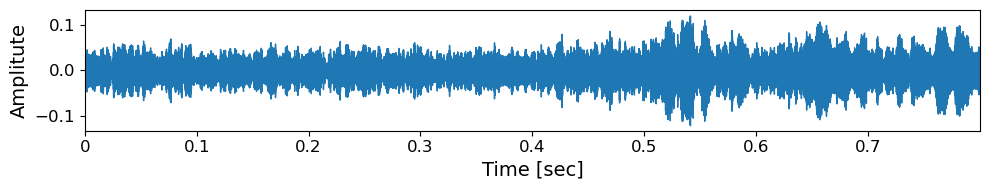

In [19]:
test = []
for seg in raw_seg[135:143]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)
simple_visualization(test)

In [13]:
ipd.Audio(test, rate=44100)

139


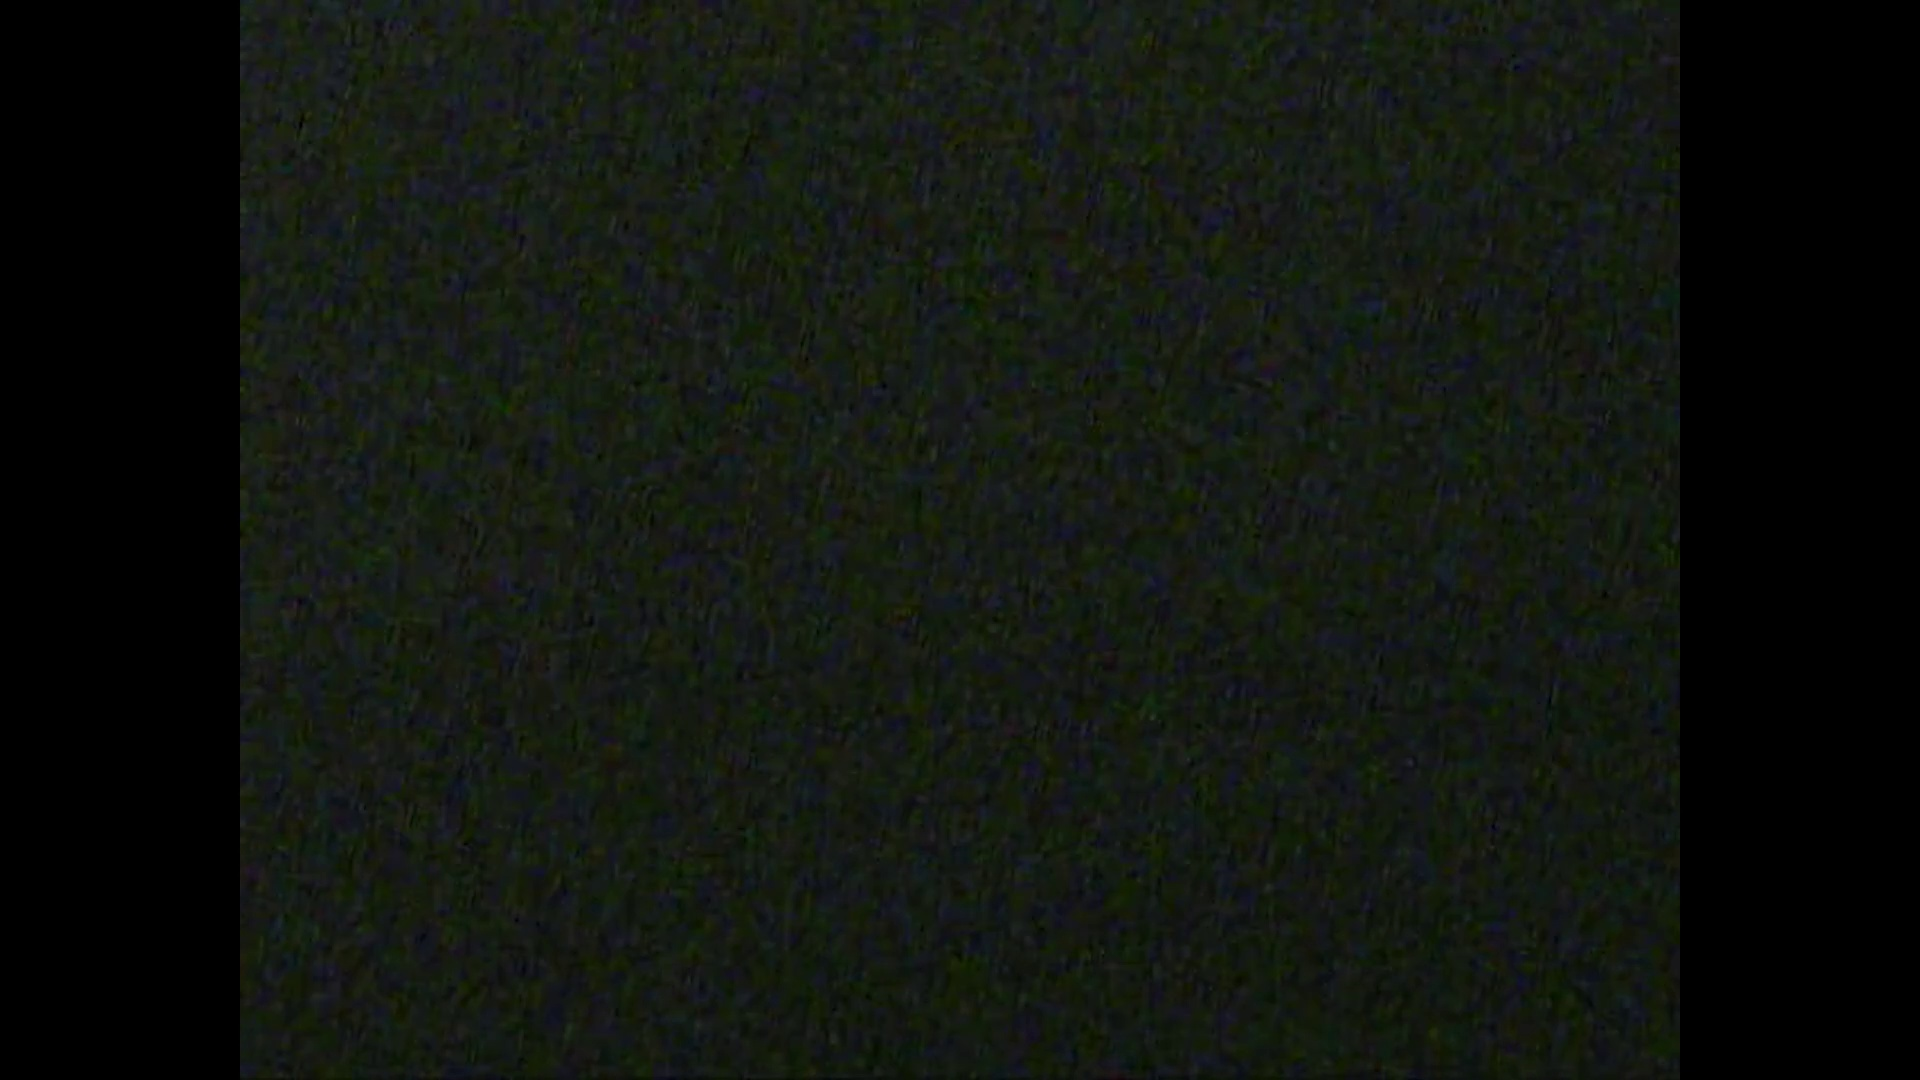

Saving figure example_139
140


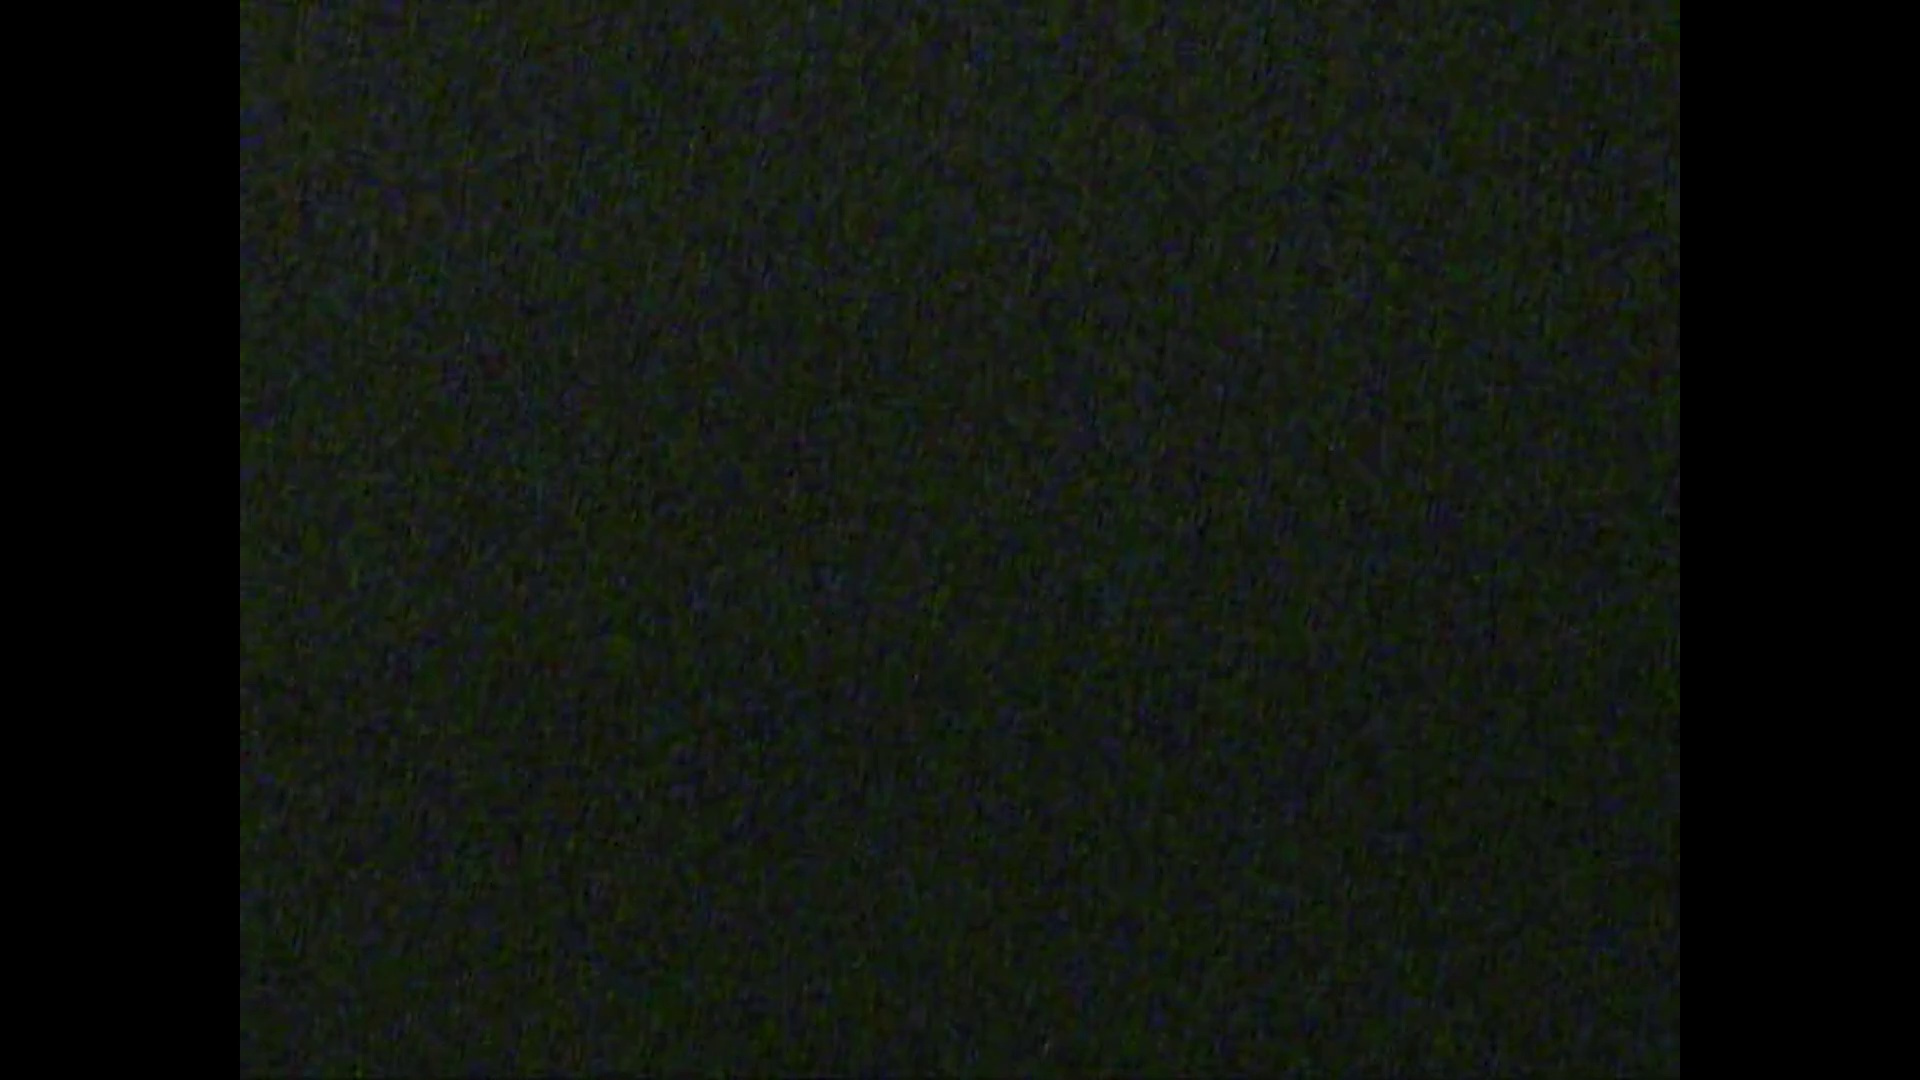

Saving figure example_140
141


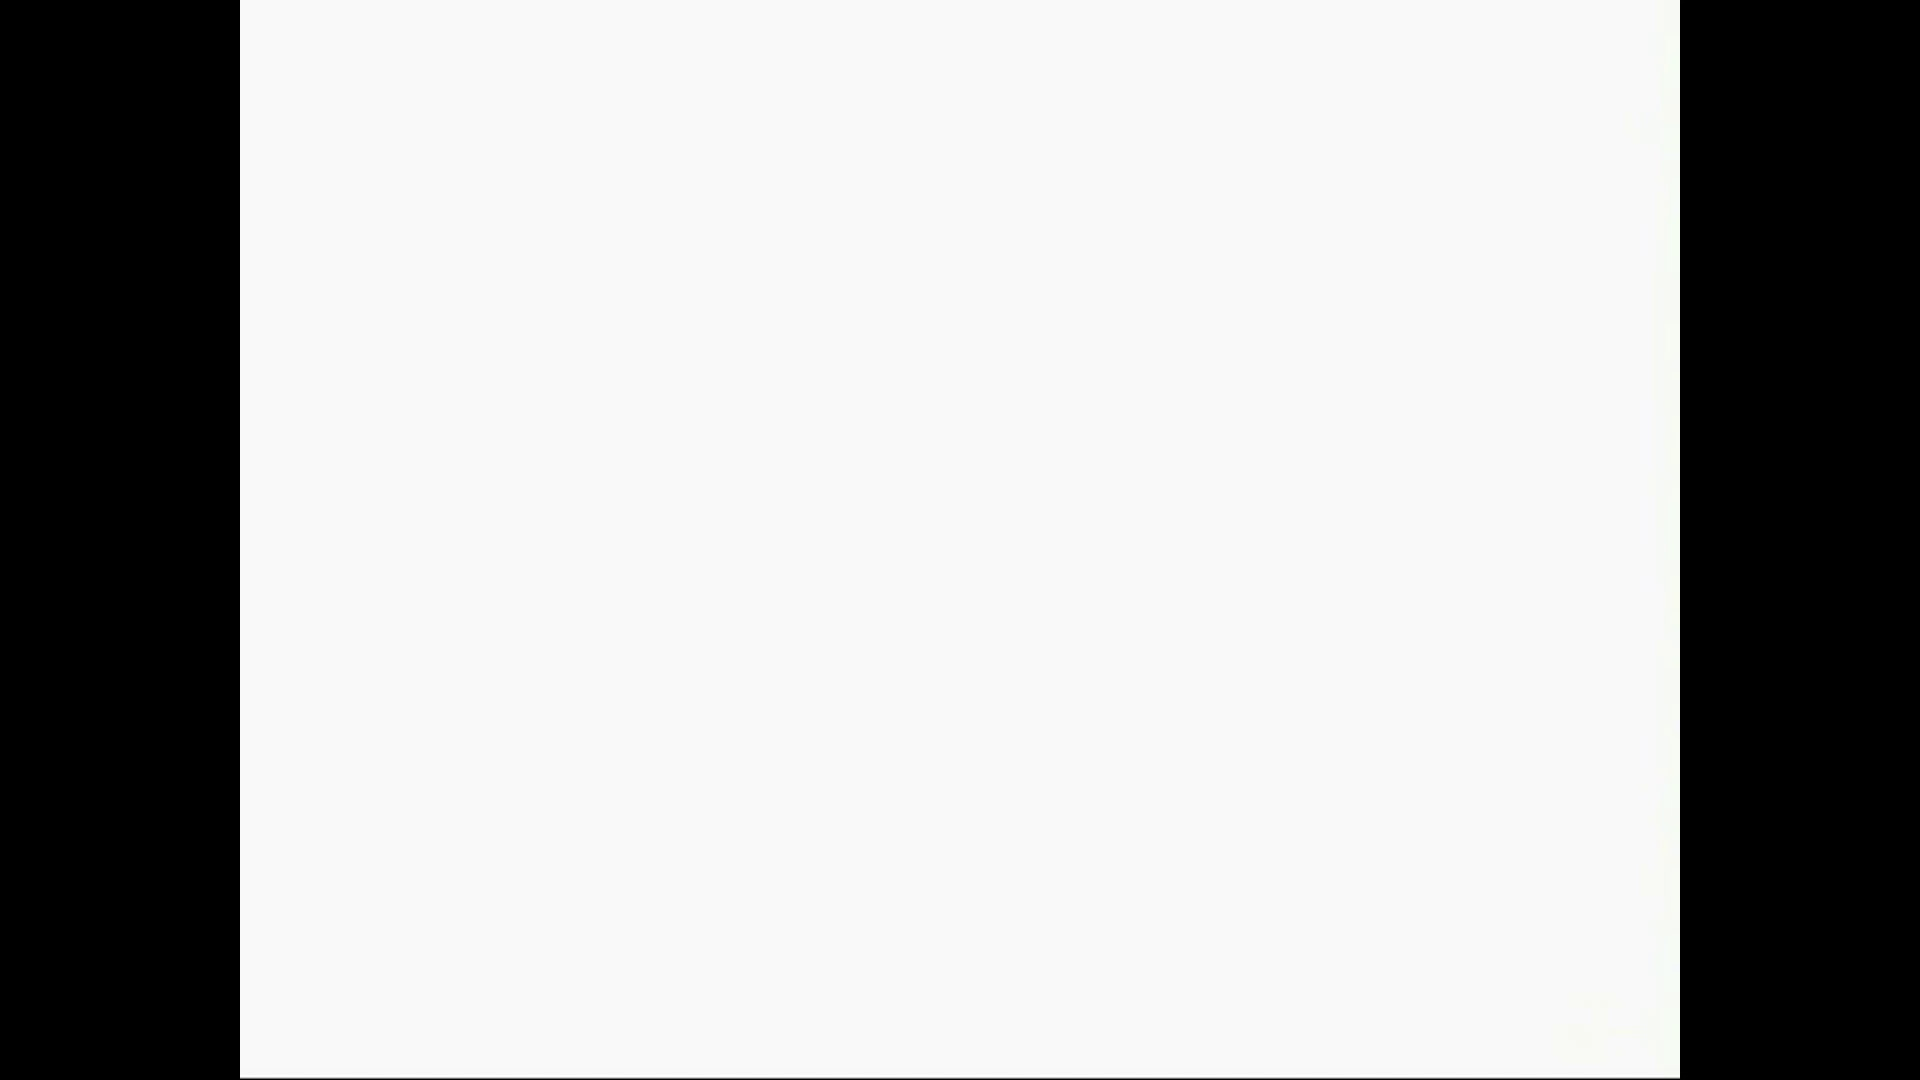

Saving figure example_141
142


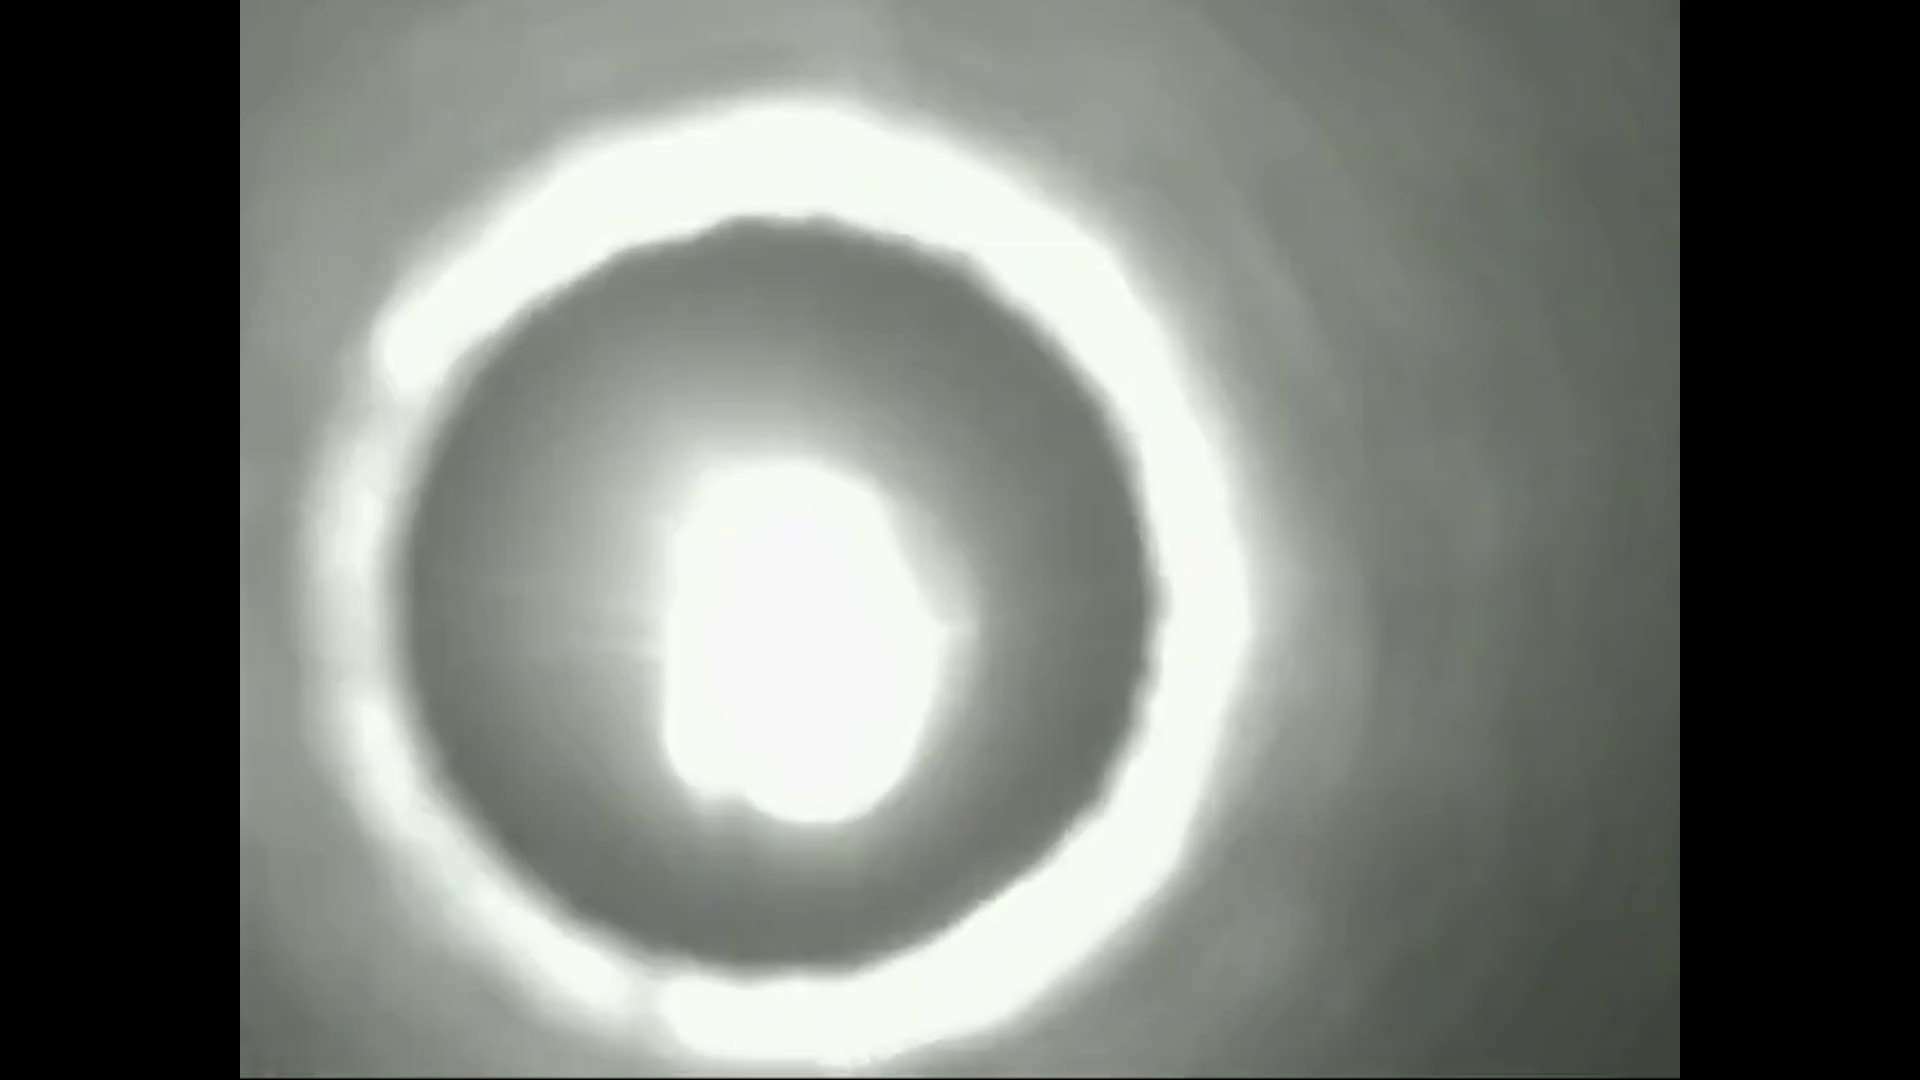

Saving figure example_142


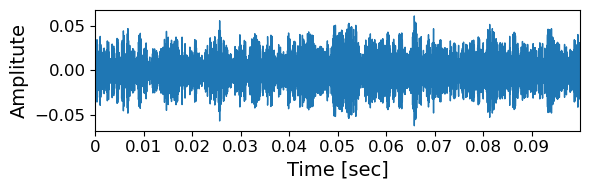

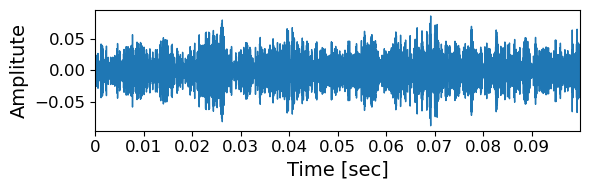

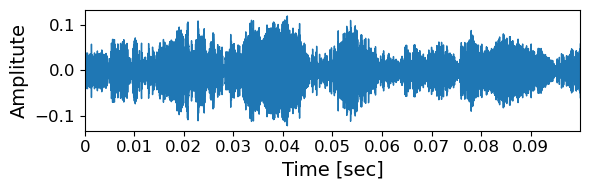

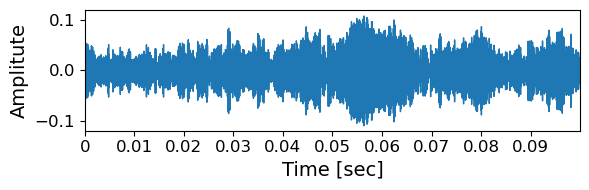

In [30]:
for i in range(139,143):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(denoised_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))
    save_fig(f'example_{i}')

Saving figure example_mfcc_defect_free


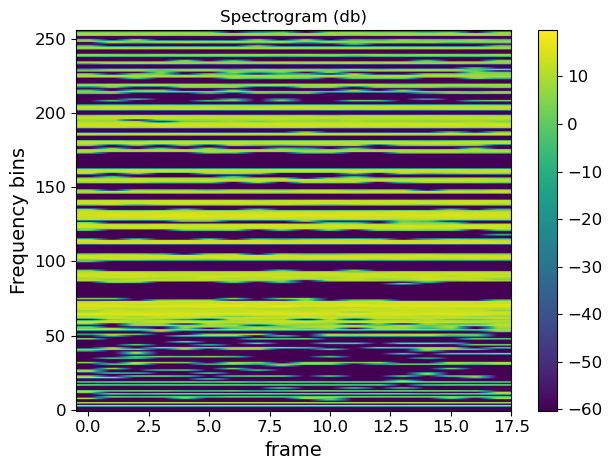

In [47]:
n_fft = 512
win_length = None
hop_length = 256
n_mels = 256
n_mfcc = 256


## defective example
# segment_audio, sr = librosa.load(os.path.join(denoised_audio_output_folder, 'sample_24_layer_57_24.wav'), sr=None) 
#laser-off
# segment_audio, sr = librosa.load(os.path.join(denoised_audio_output_folder, 'sample_24_759.wav'), sr=None) 
#defect-free
segment_audio, sr = librosa.load(os.path.join(denoised_audio_output_folder, 'sample_24_438.wav'), sr=None) 



melspec = librosa.feature.melspectrogram(
  y=segment_audio, sr=44100, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')


plot_spectrogram(mfcc_librosa)
save_fig("example_mfcc_defect_free")

Saving figure spectrogram_defect_free


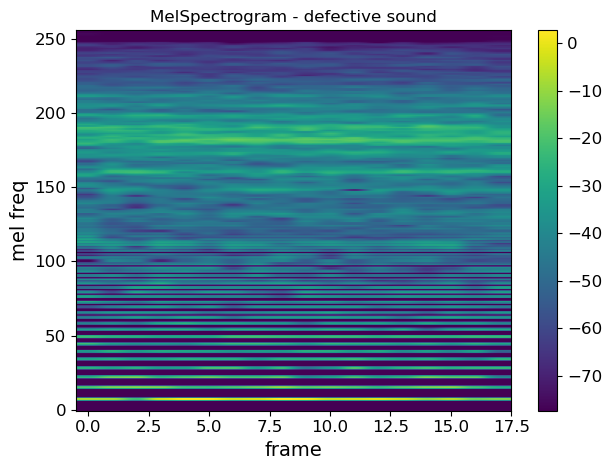

In [48]:
melspec_librosa = librosa.feature.melspectrogram(
    segment_audio,
    sr=44100,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm='slaney',
    htk=True,
)

plot_spectrogram(
    melspec_librosa, title="MelSpectrogram - defective sound", ylabel='mel freq')
save_fig("spectrogram_defect_free")

### Sample 24 Layer 32, cracks

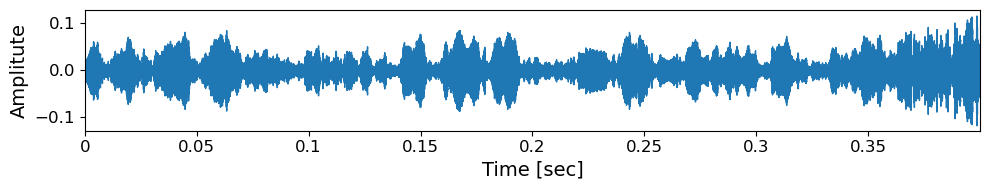

In [22]:
test = []
for seg in denoised_seg[4362:4366]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)
simple_visualization(test)

In [34]:
ipd.Audio(test, rate=44100)

4362


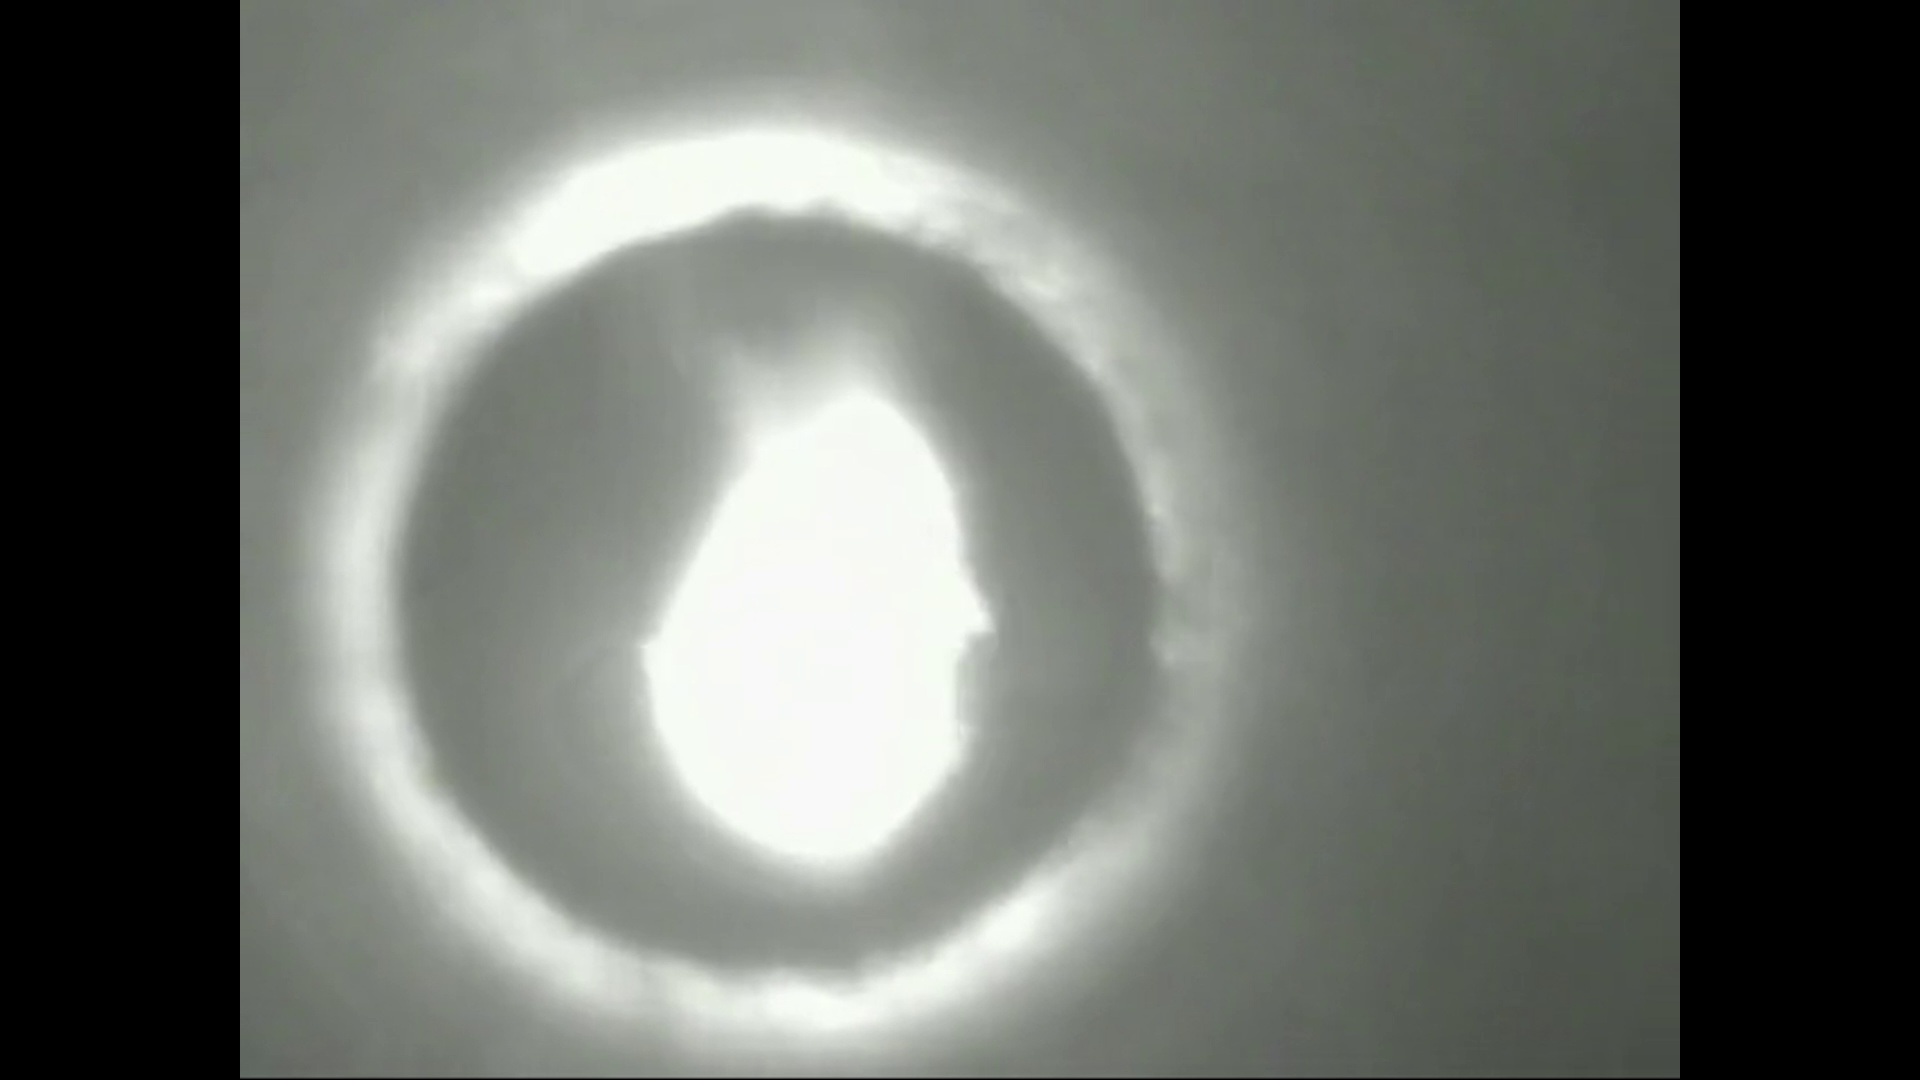

4363


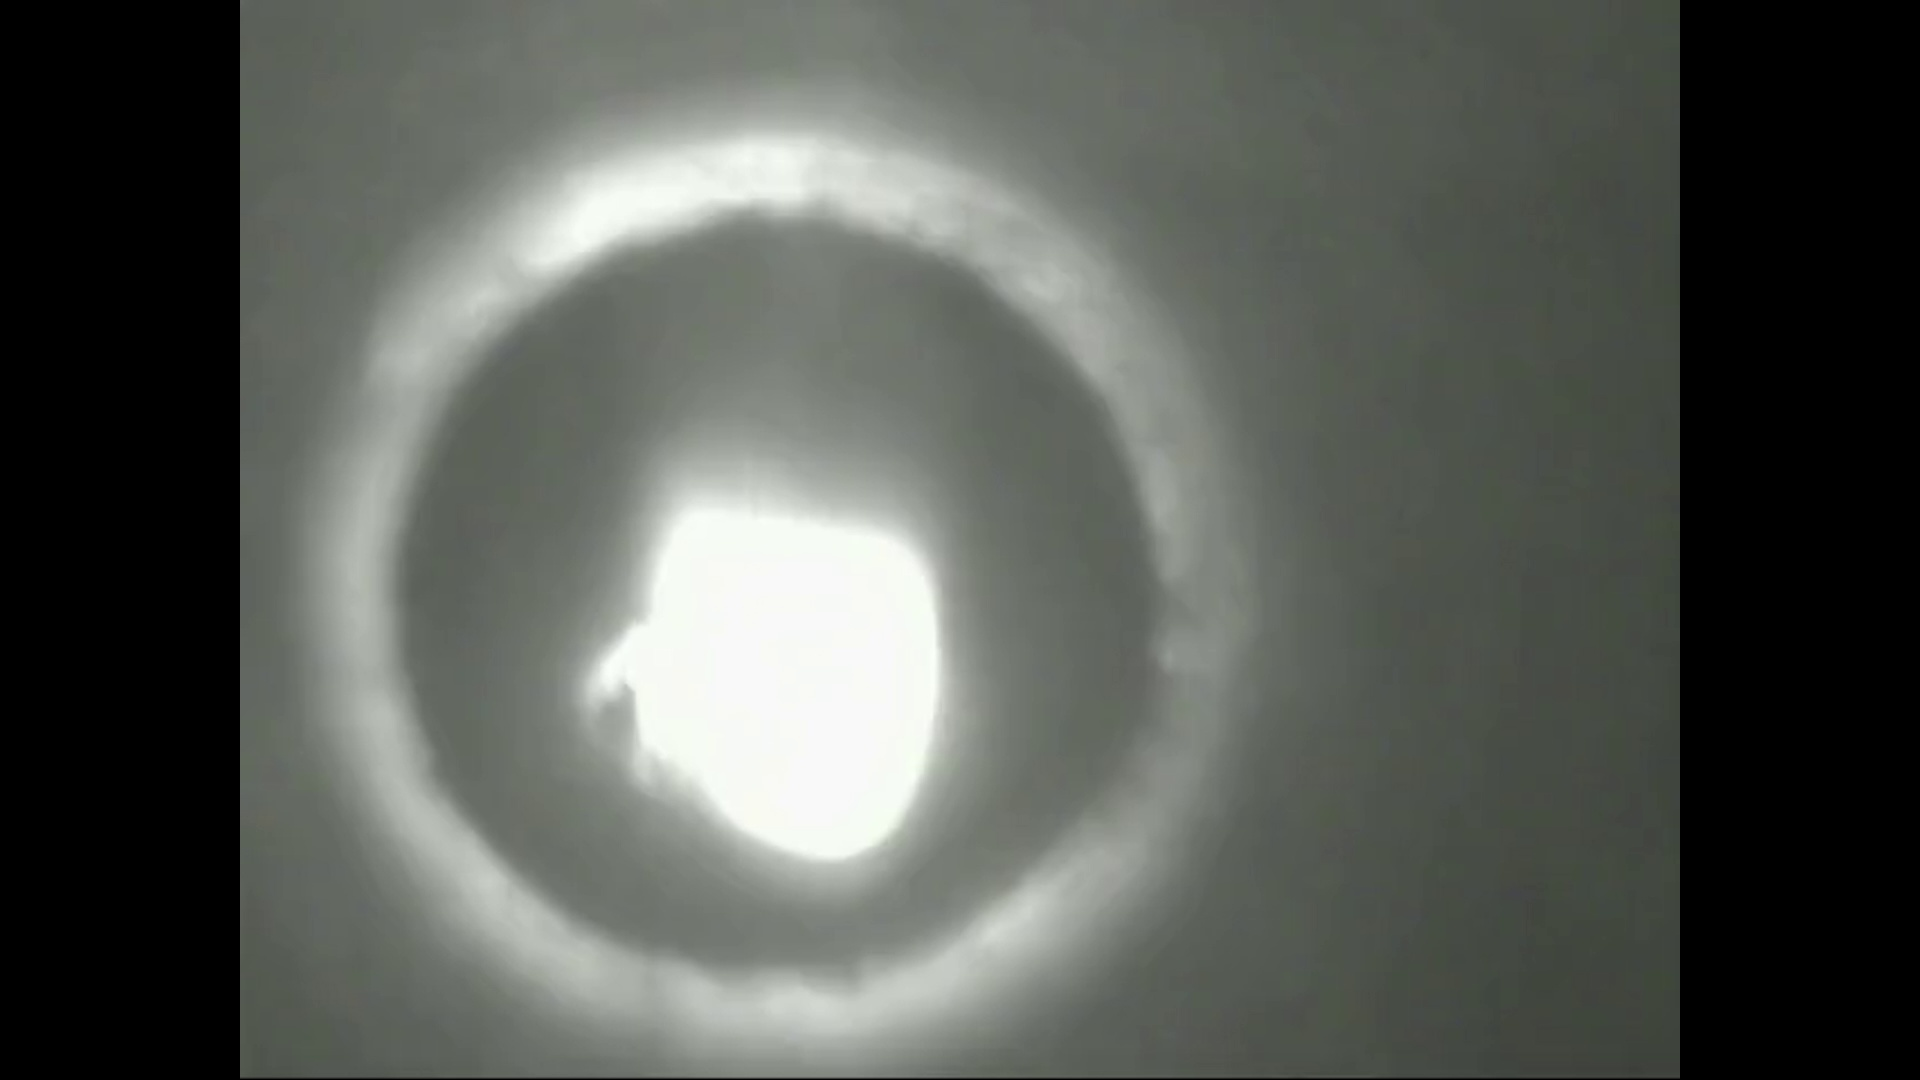

4364


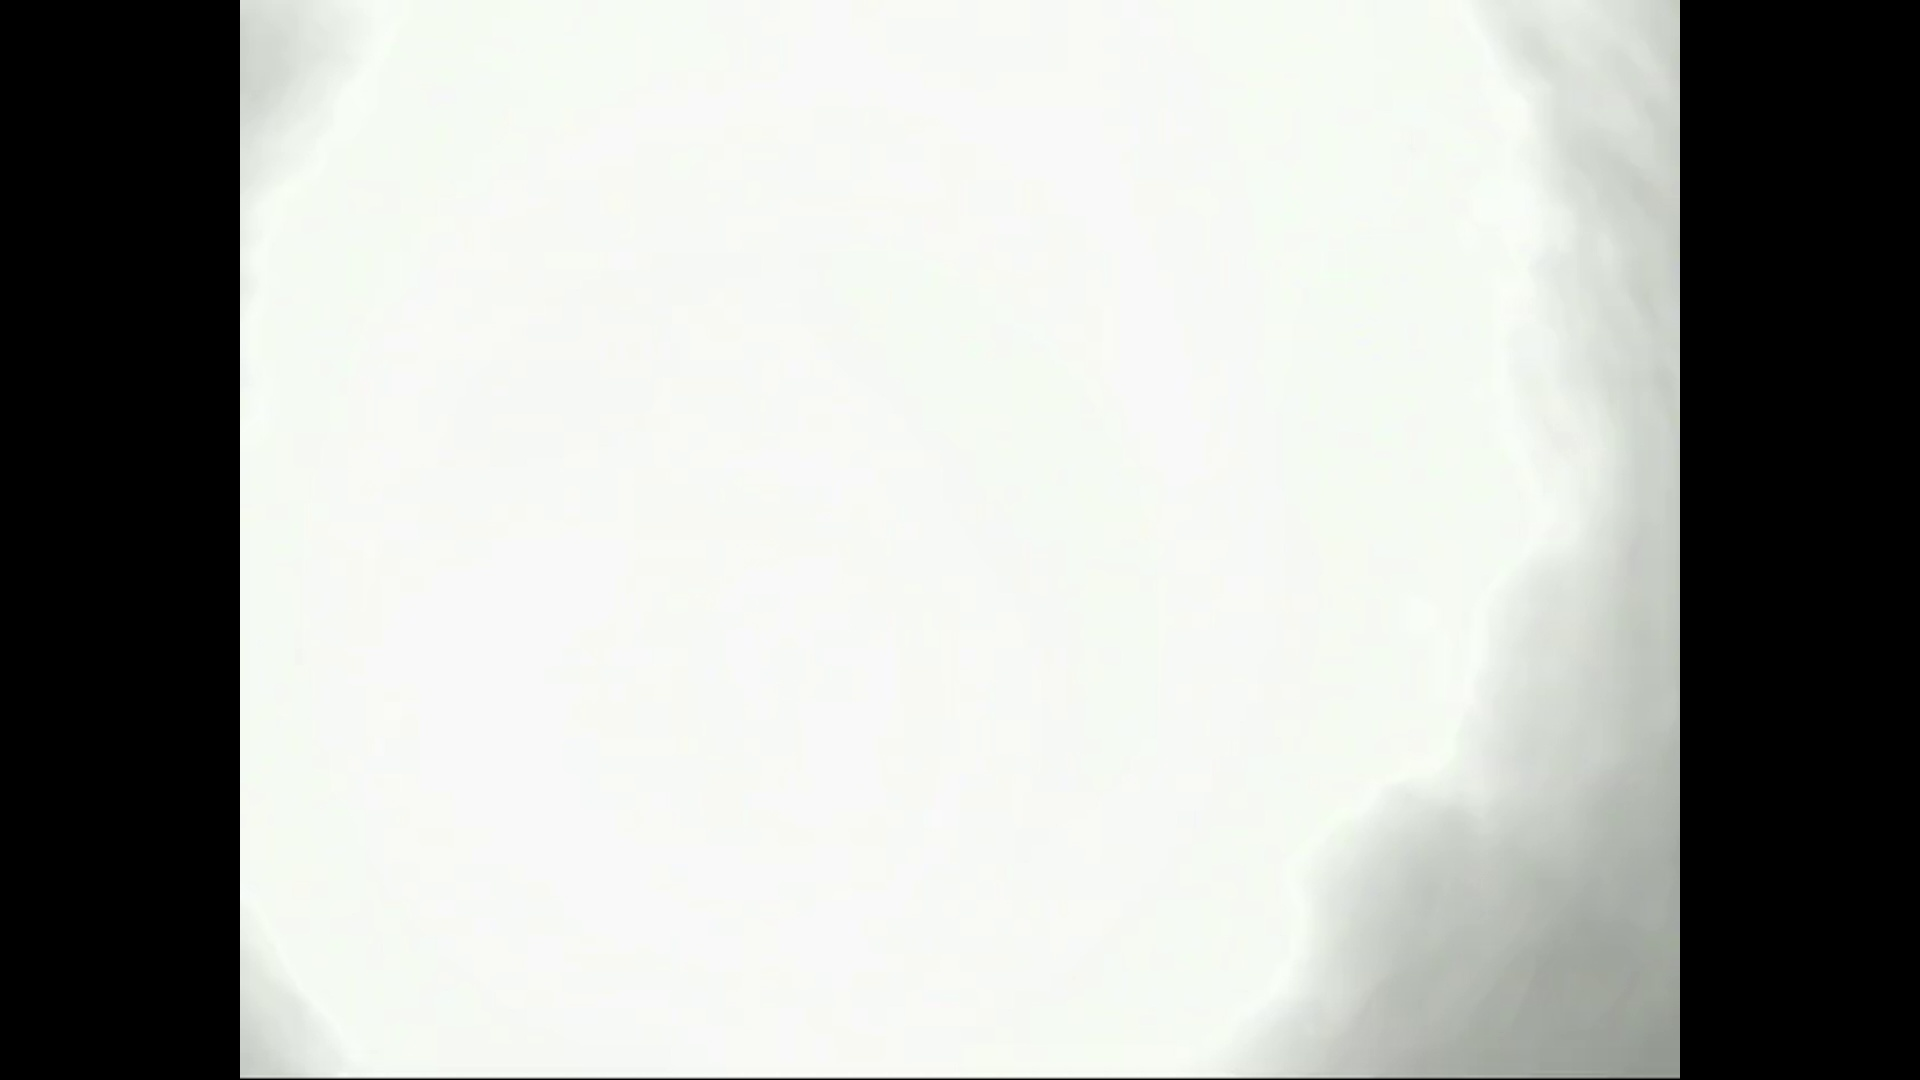

4365


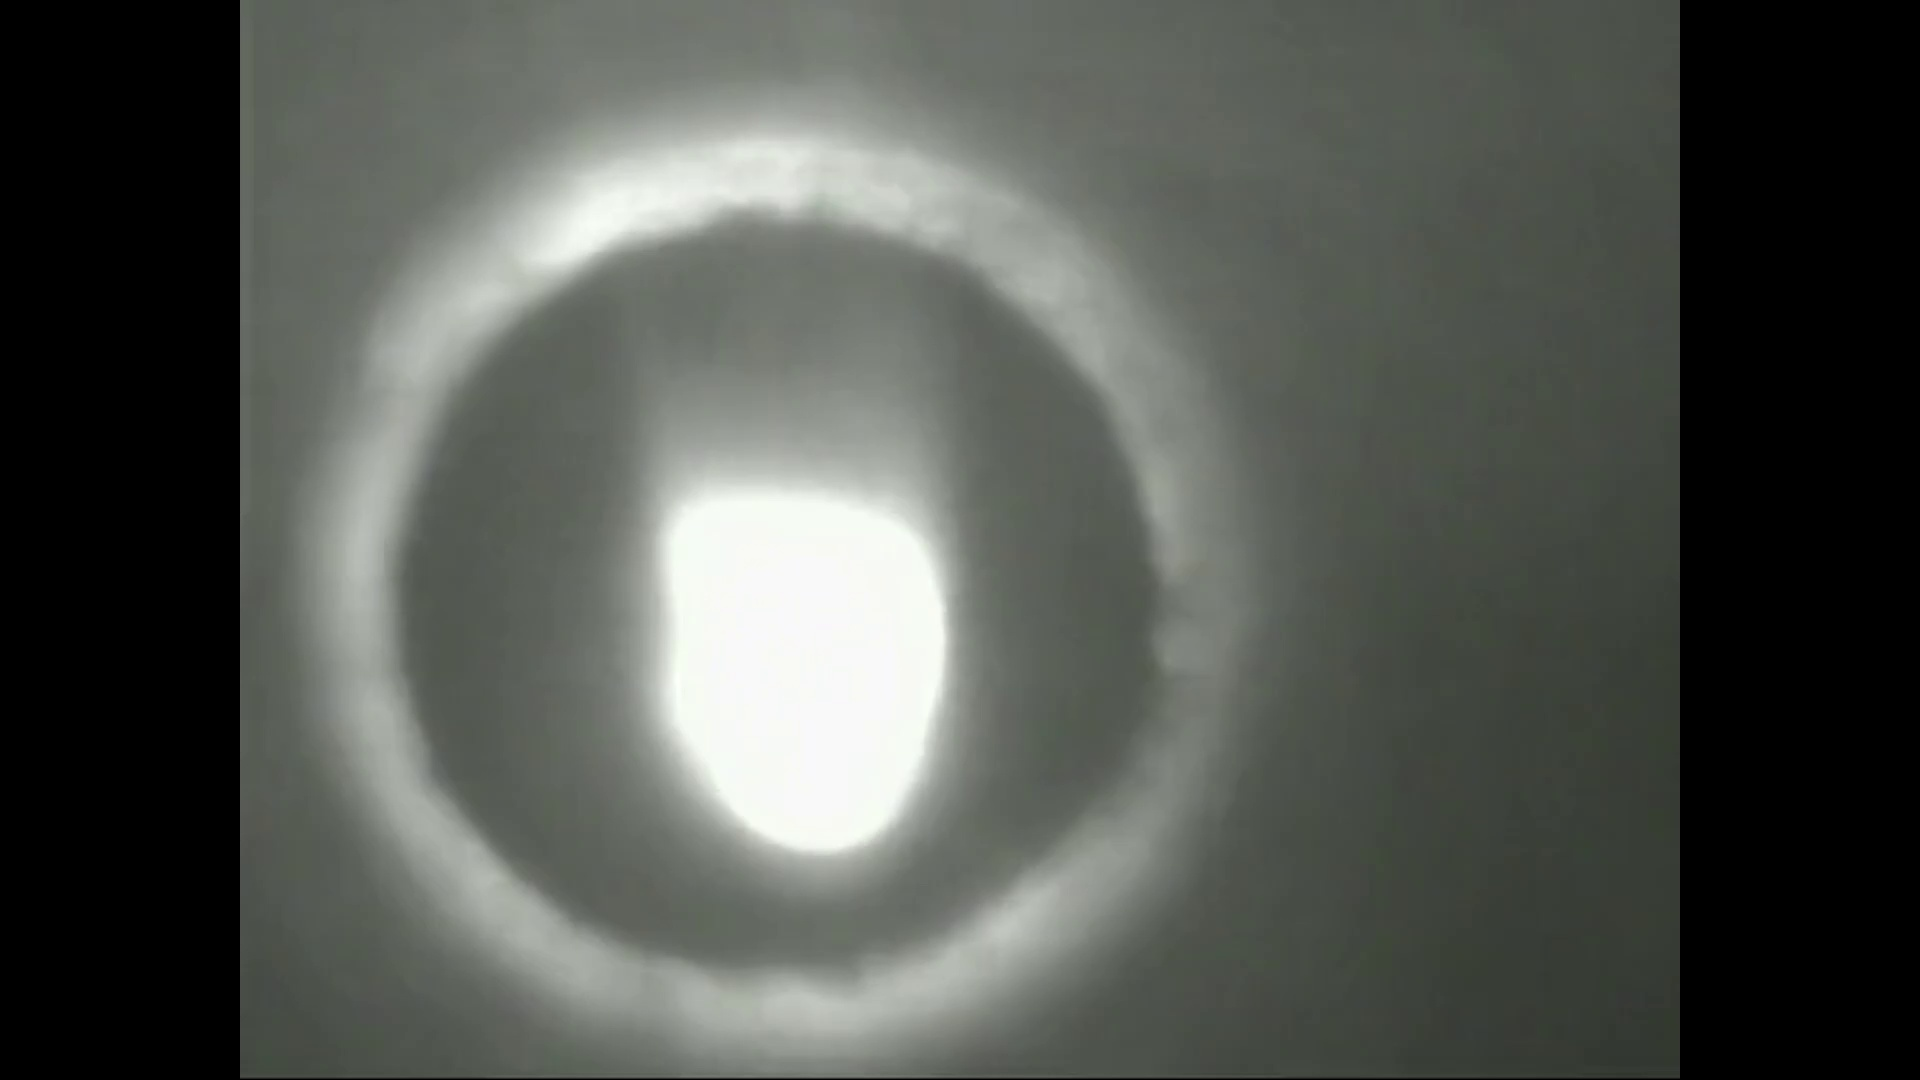

4366


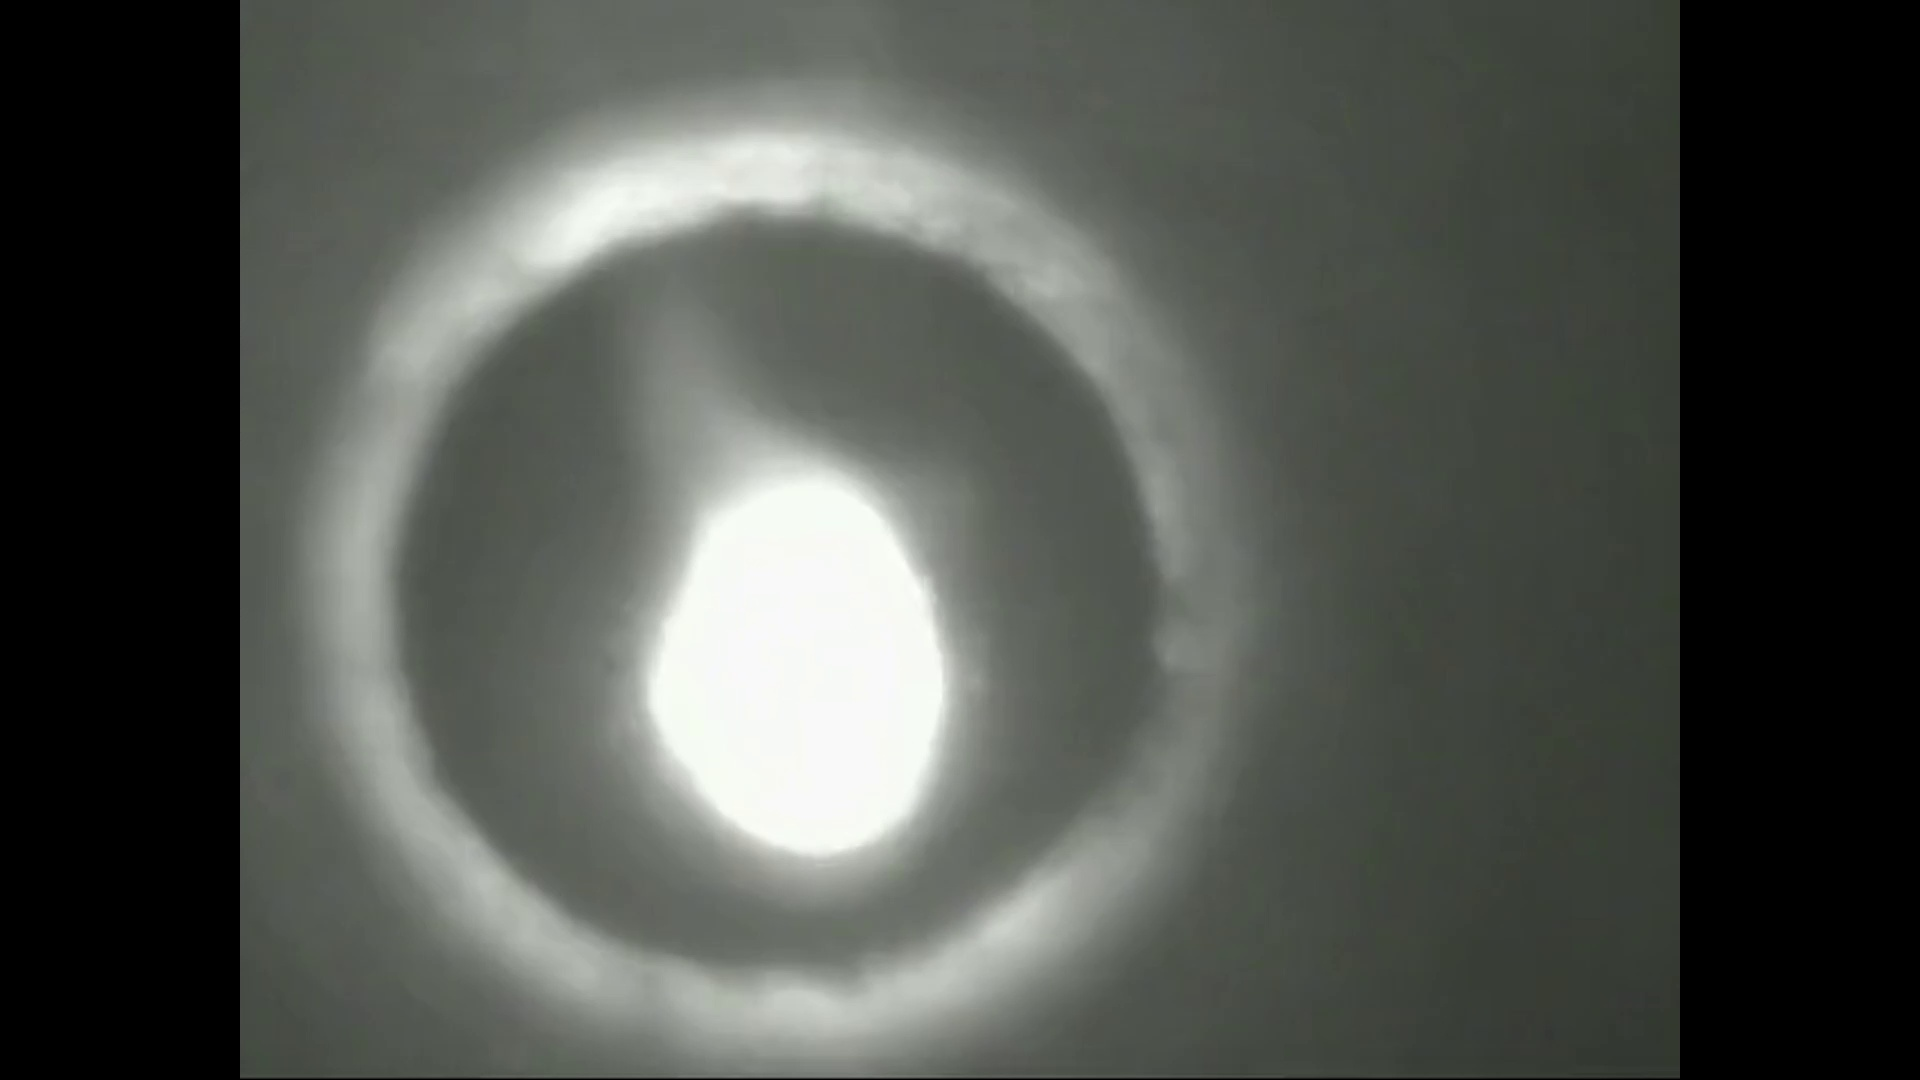

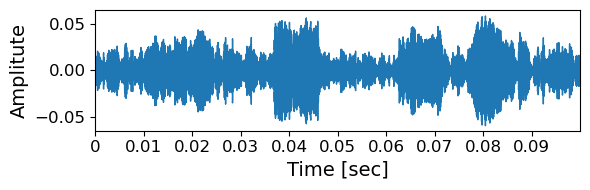

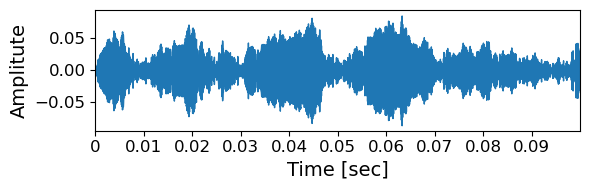

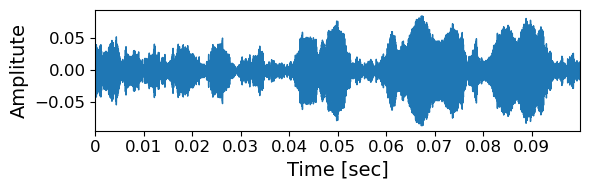

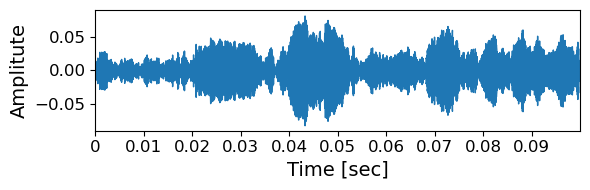

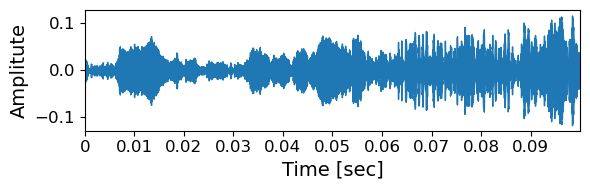

In [34]:
for i in range(4362,4367):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

### Sample 23 

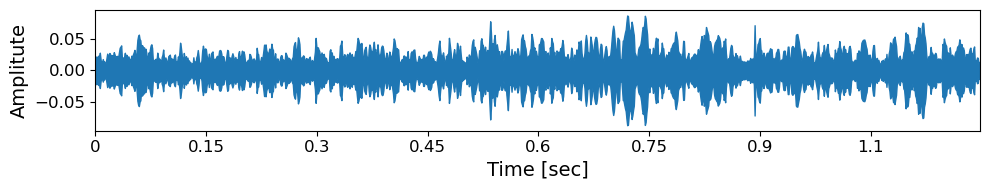

In [42]:
test = []
for seg in denoised_seg[3339:3351]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)
simple_visualization(test)

In [37]:
n_fft = 512
win_length = None
hop_length = 256
n_mels = 256
n_mfcc = 256


melspec = librosa.feature.melspectrogram(
  y=segment_audio, sr=44100, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')


melspec_librosa = librosa.feature.melspectrogram(
    test,
    sr=44100,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm='slaney',
    htk=True,
)

# plot_spectrogram(mfcc_librosa)
# save_fig("mfcc_23")

Saving figure spectrogram_23


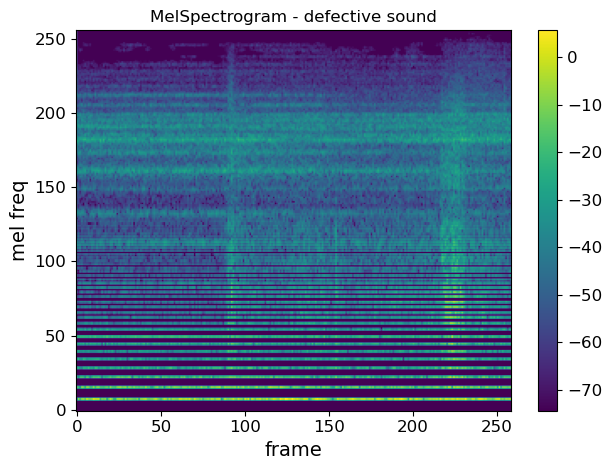

In [38]:
plot_spectrogram(
    melspec_librosa, title="MelSpectrogram - defective sound", ylabel='mel freq')
save_fig("spectrogram_23")

In [39]:
ipd.Audio(test, rate=44100)

3339


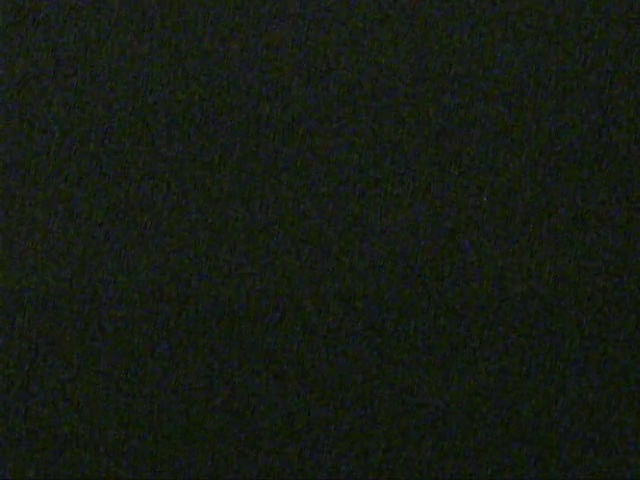

3340


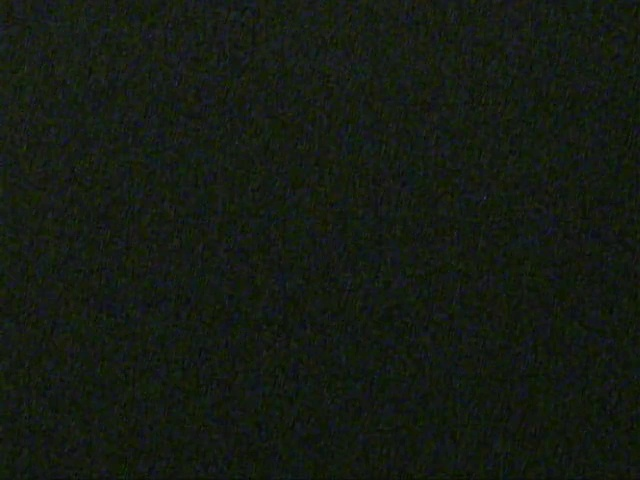

3341


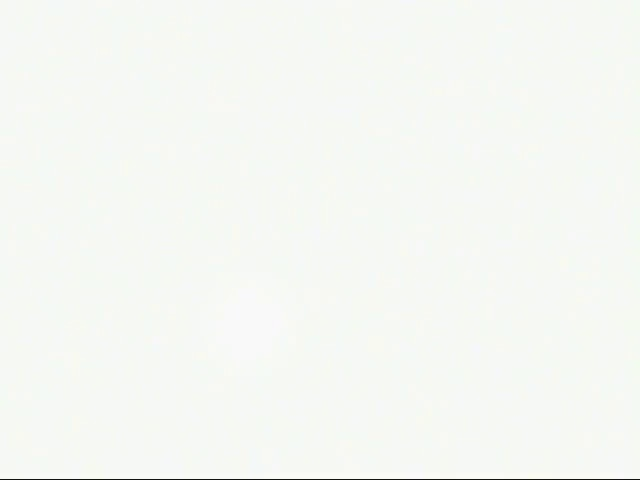

3342


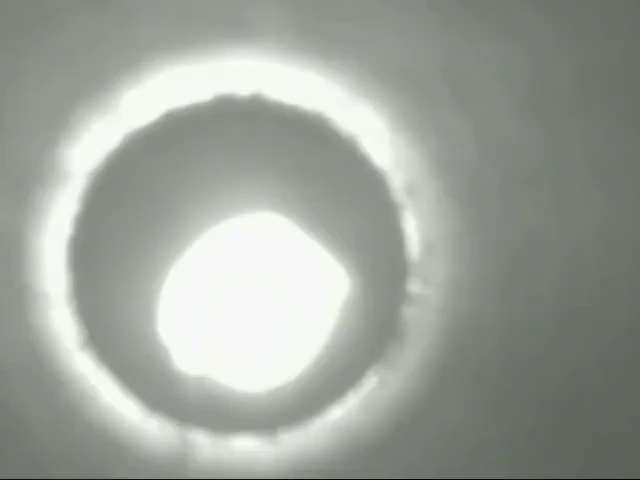

3343


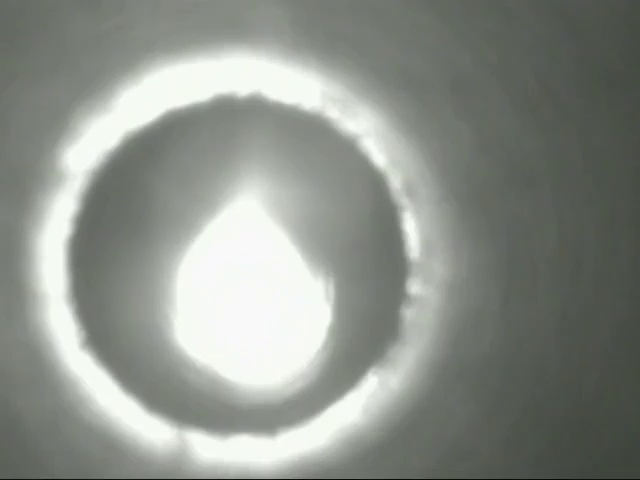

3344


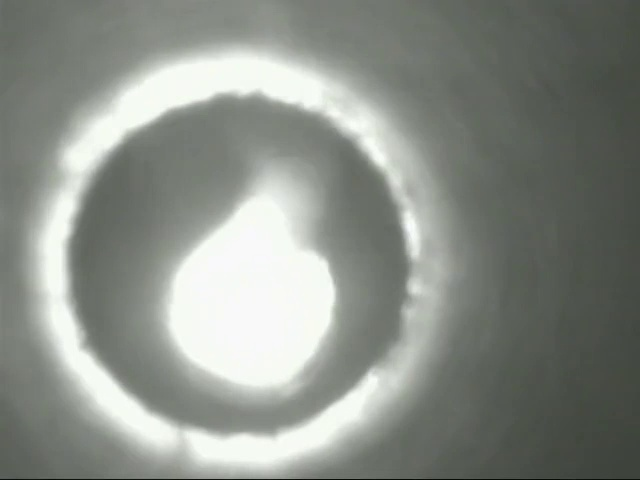

3345


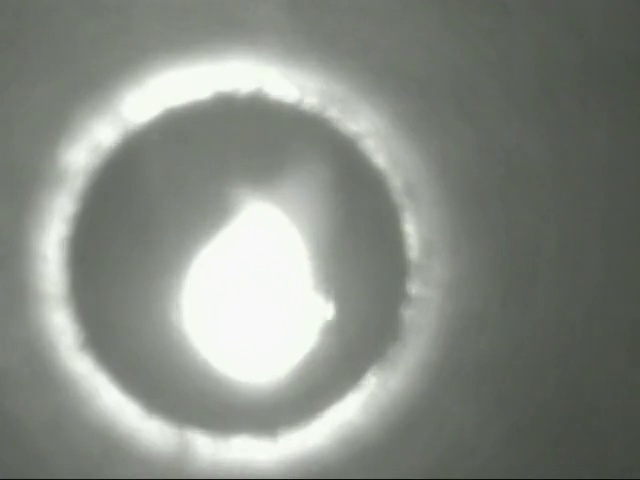

3346


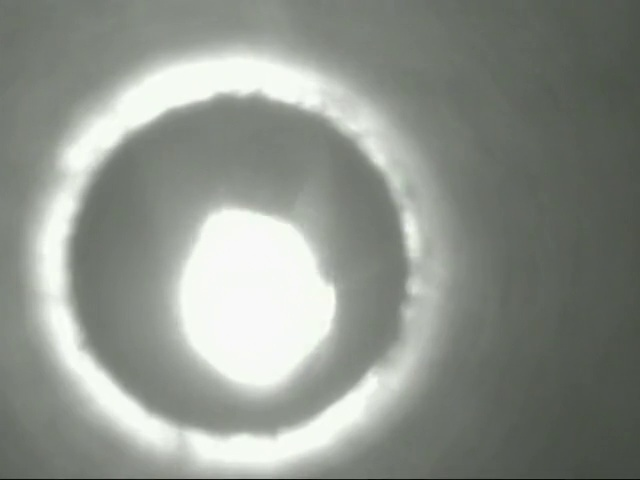

3347


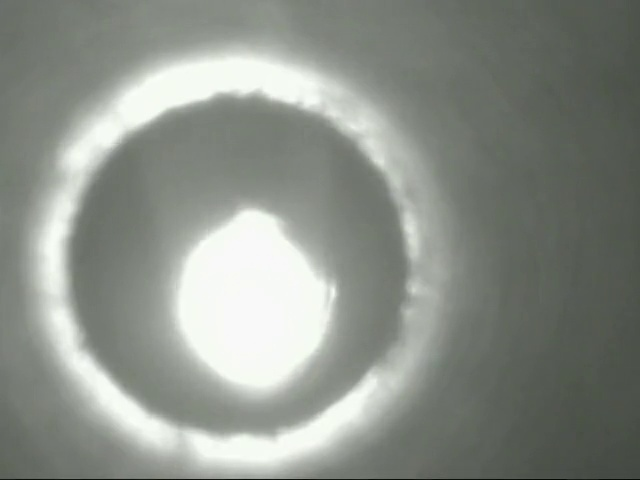

3348


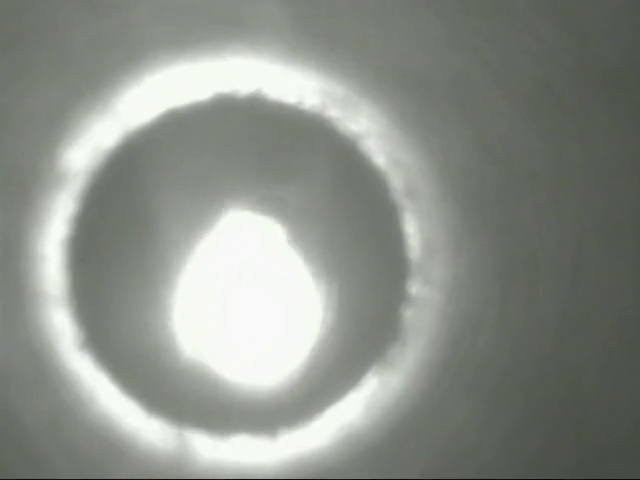

3349


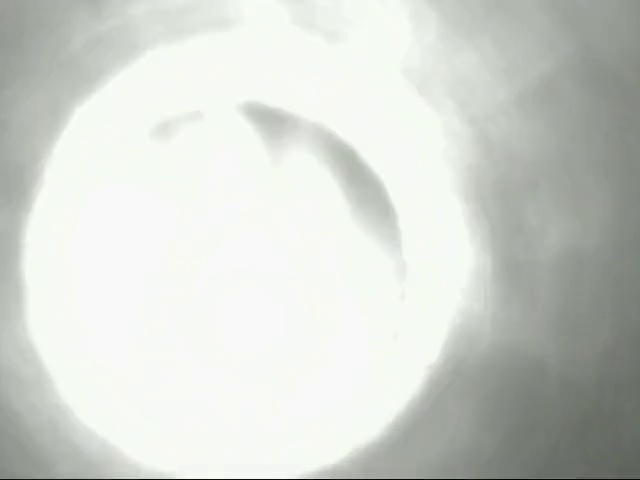

3350


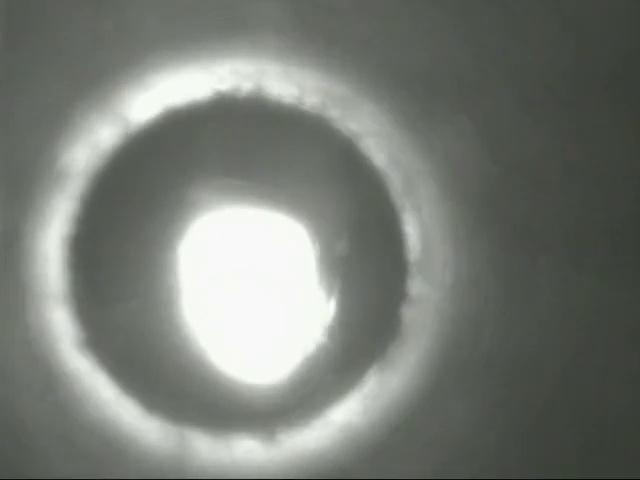

3351


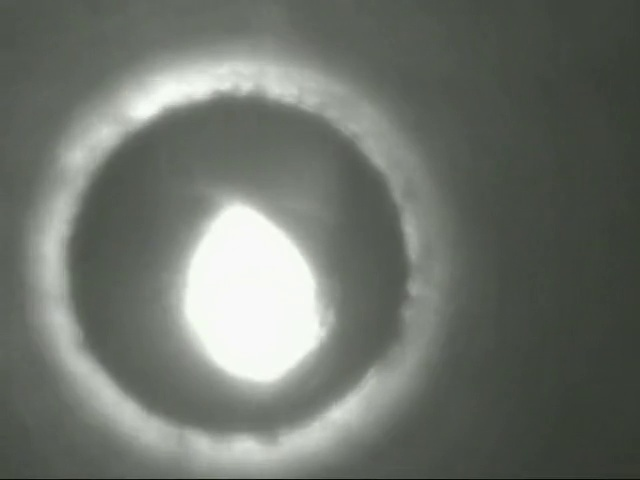

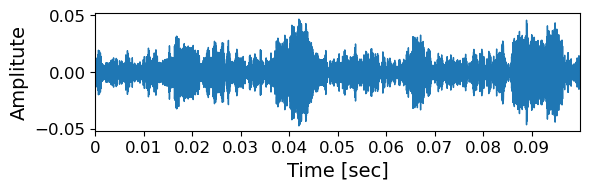

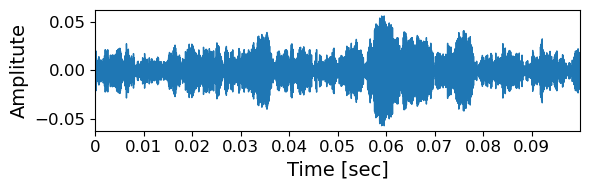

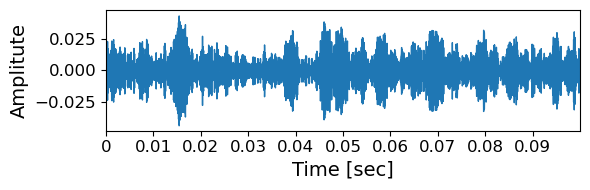

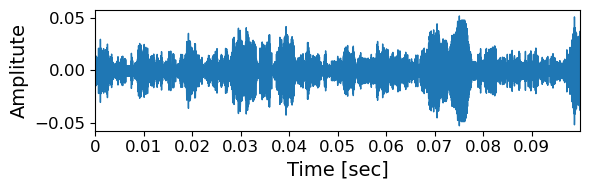

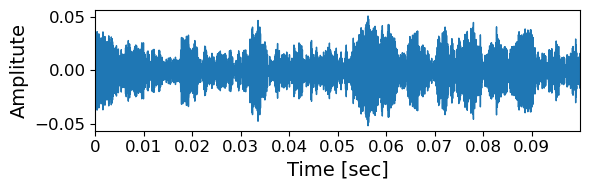

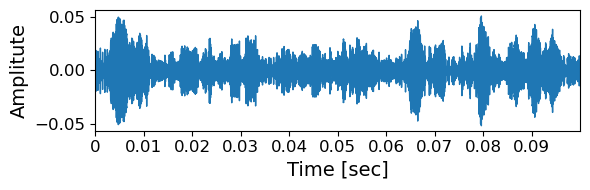

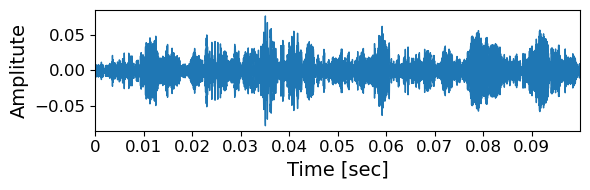

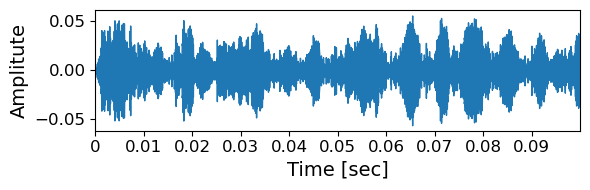

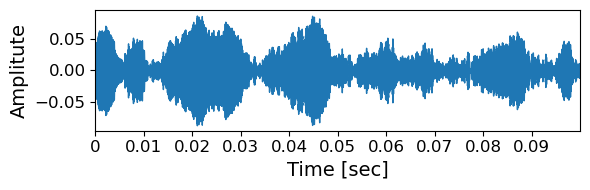

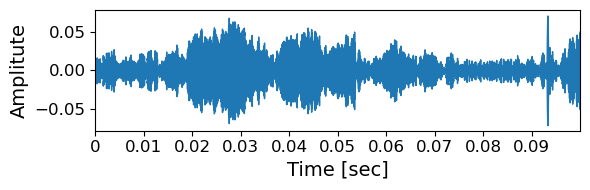

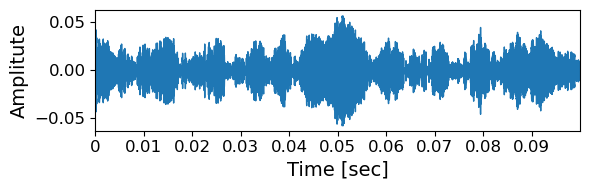

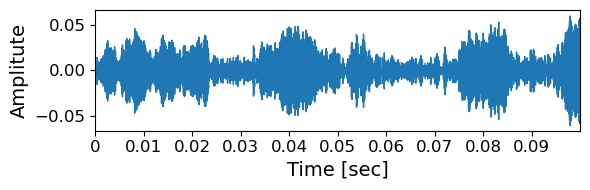

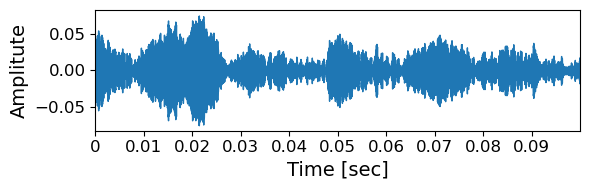

In [40]:
for i in range(3339,3352):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

### Sample 26

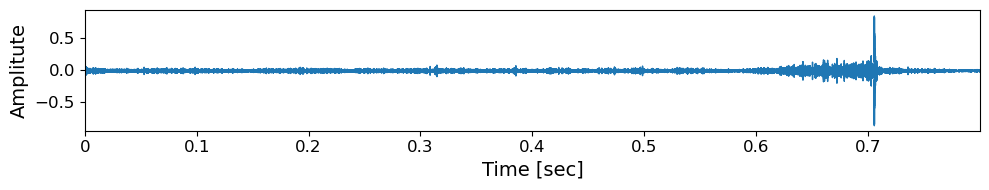

In [67]:
test = []
for seg in denoised_seg[3337:3345]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)
simple_visualization(test)

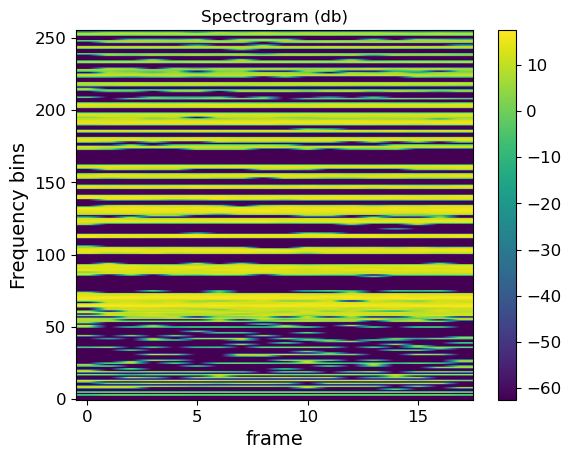

In [68]:
n_fft = 512
win_length = None
hop_length = 256
n_mels = 256
n_mfcc = 256


melspec = librosa.feature.melspectrogram(
  y=segment_audio, sr=44100, n_fft=n_fft,
  win_length=win_length, hop_length=hop_length,
  n_mels=n_mels, htk=True, norm=None)

mfcc_librosa = librosa.feature.mfcc(
  S=librosa.core.spectrum.power_to_db(melspec),
  n_mfcc=n_mfcc, dct_type=2, norm='ortho')


melspec_librosa = librosa.feature.melspectrogram(
    test,
    sr=44100,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm='slaney',
    htk=True,
)

plot_spectrogram(mfcc_librosa)
# save_fig("mfcc_26")

Saving figure spectrogram_26


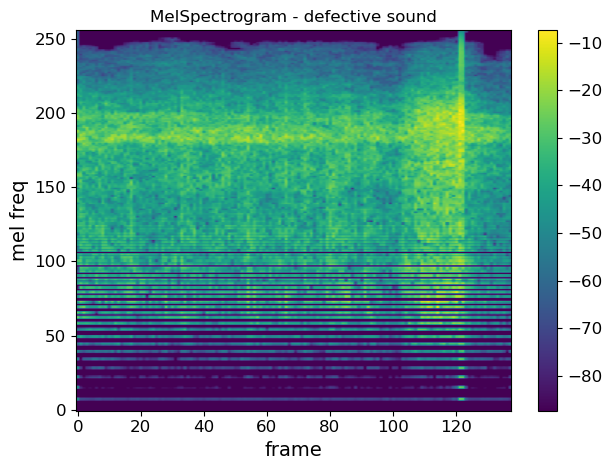

In [69]:
plot_spectrogram(
    melspec_librosa, title="MelSpectrogram - defective sound", ylabel='mel freq')
save_fig("spectrogram_26")

In [70]:
ipd.Audio(test, rate=44100)

3337


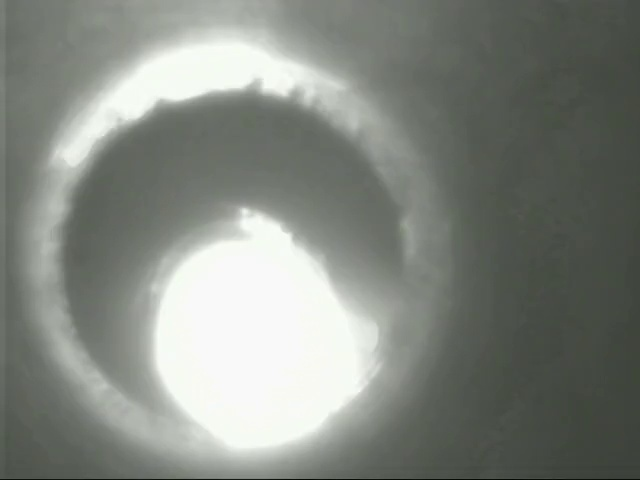

3338


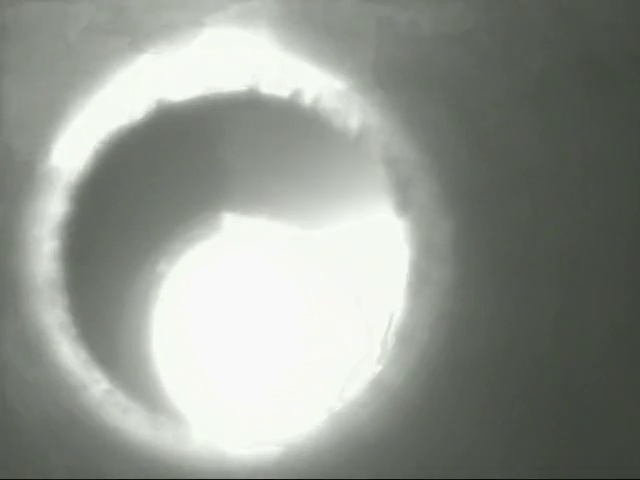

3339


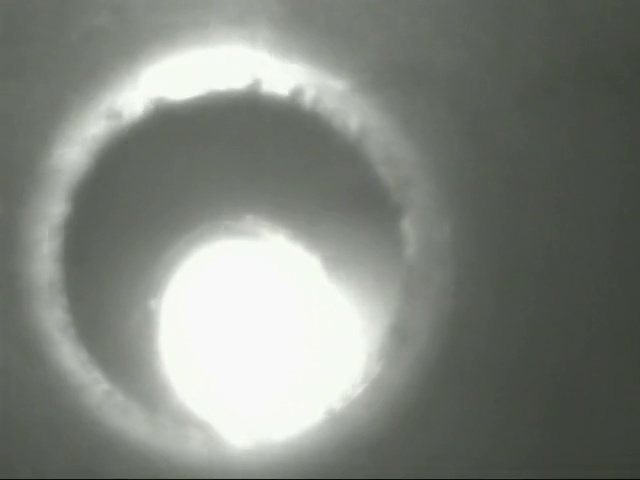

3340


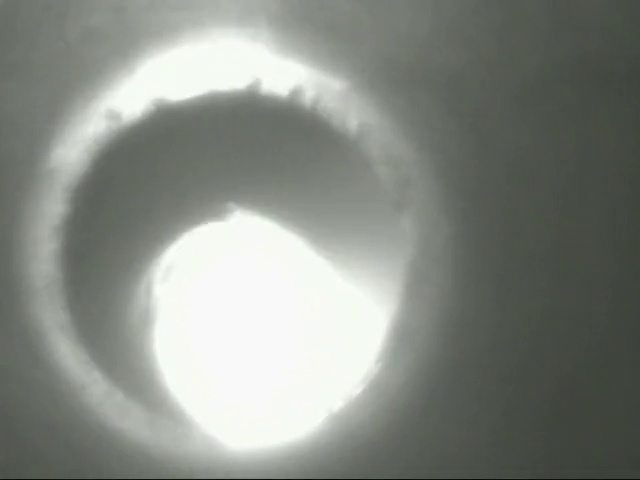

3341


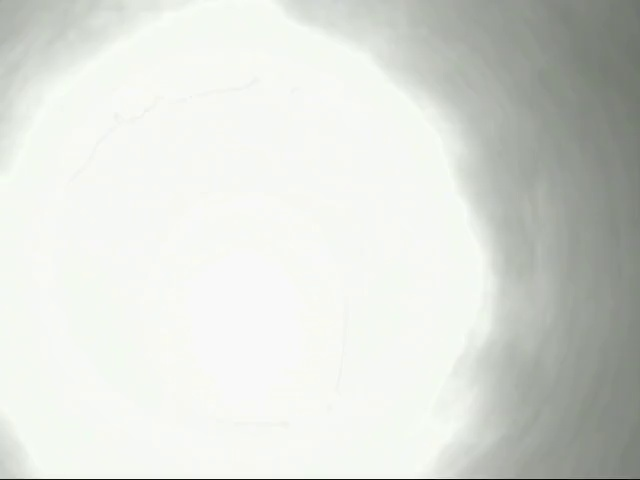

3342


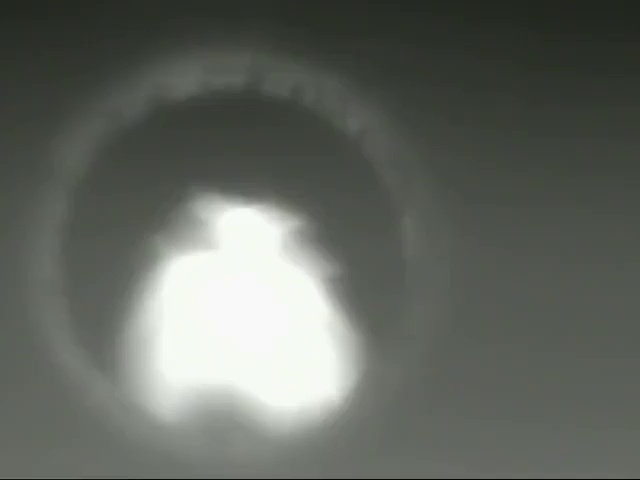

3343


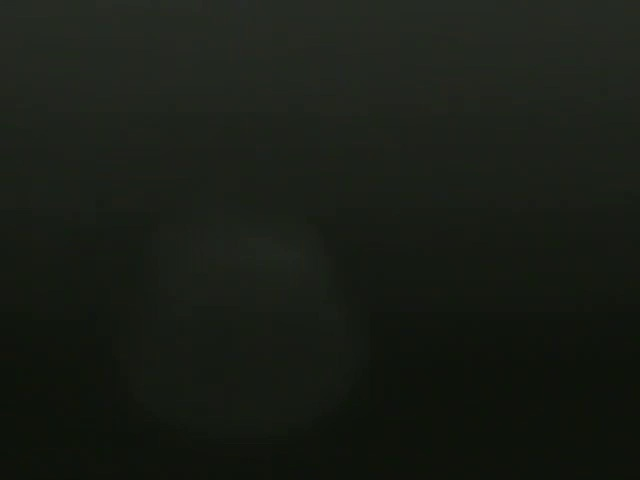

3344


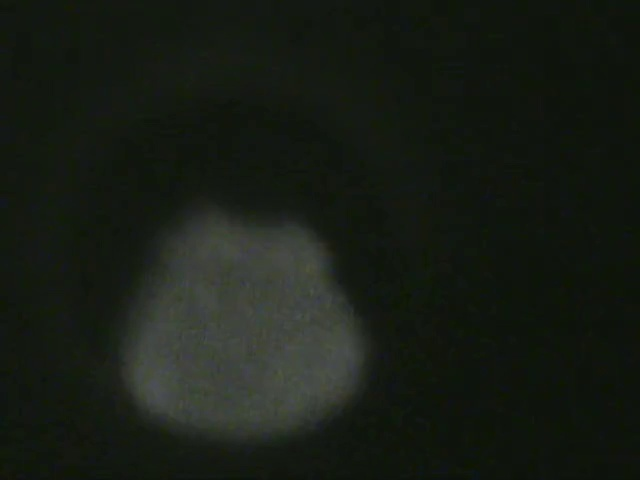

3345


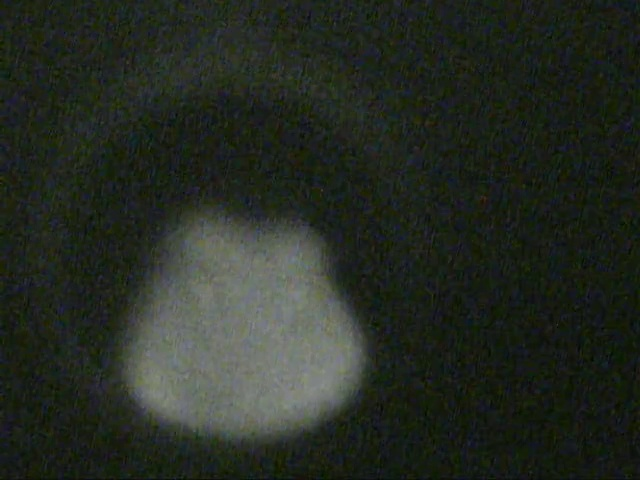

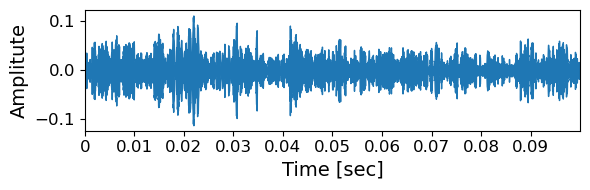

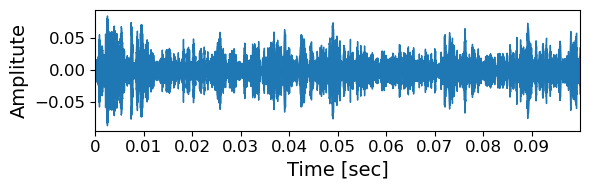

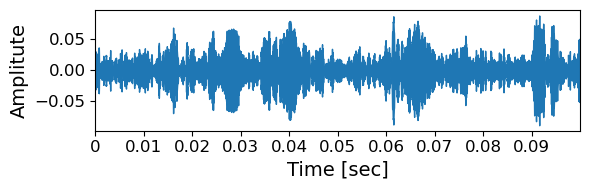

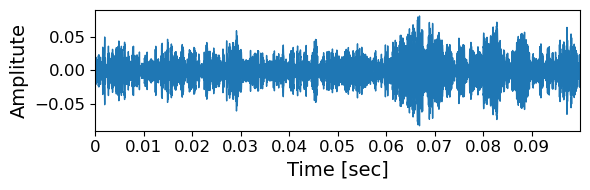

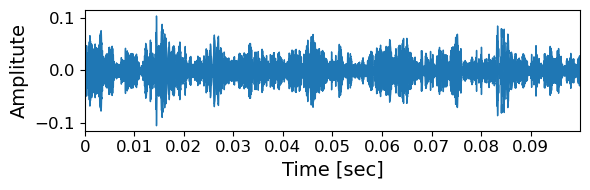

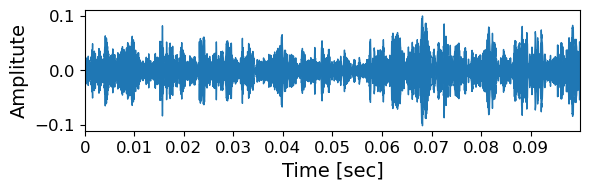

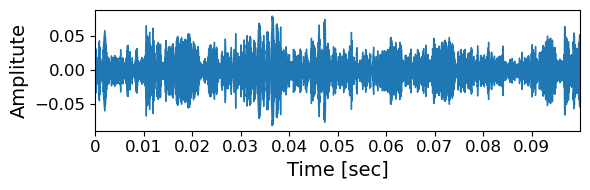

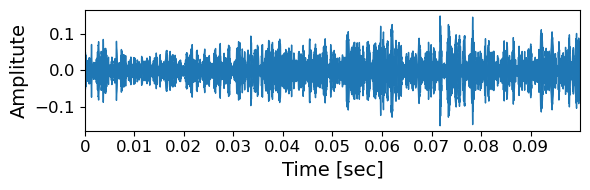

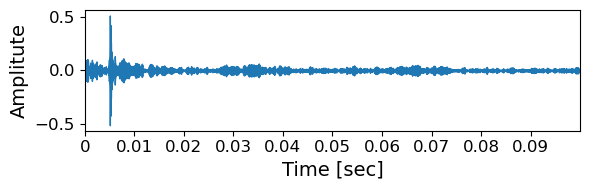

In [72]:
for i in range(3337,3346):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

### Sample 22

3339


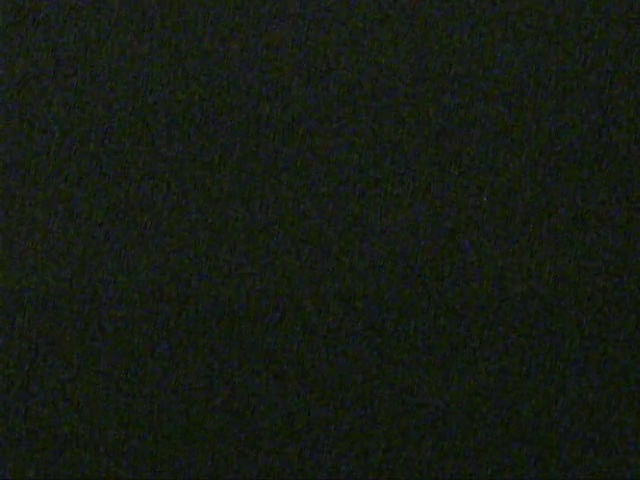

3340


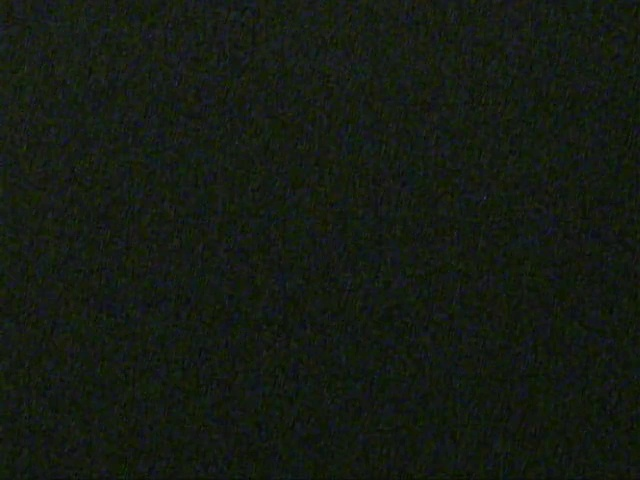

3341


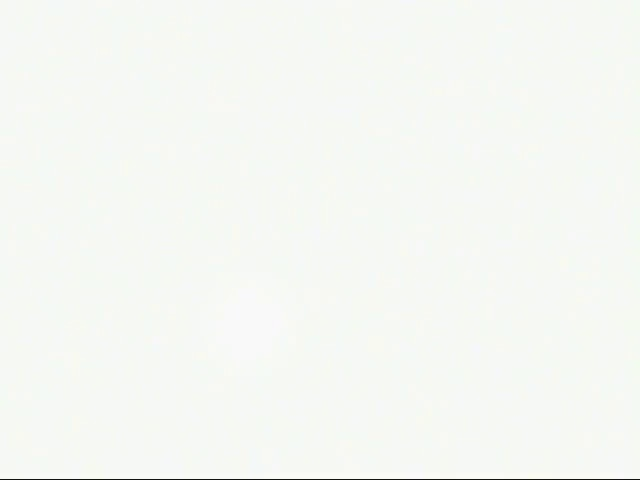

3342


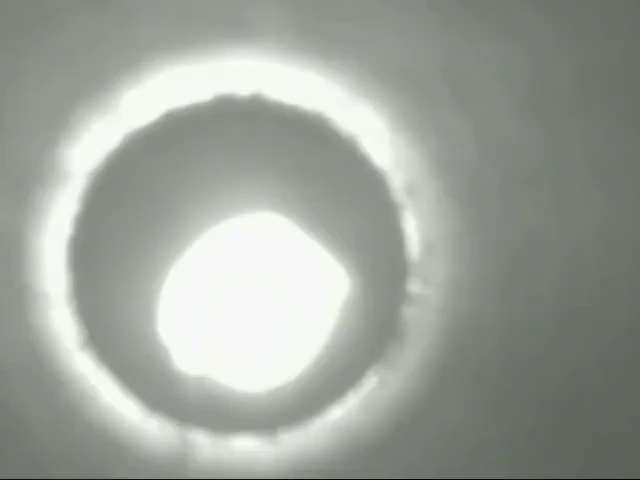

3343


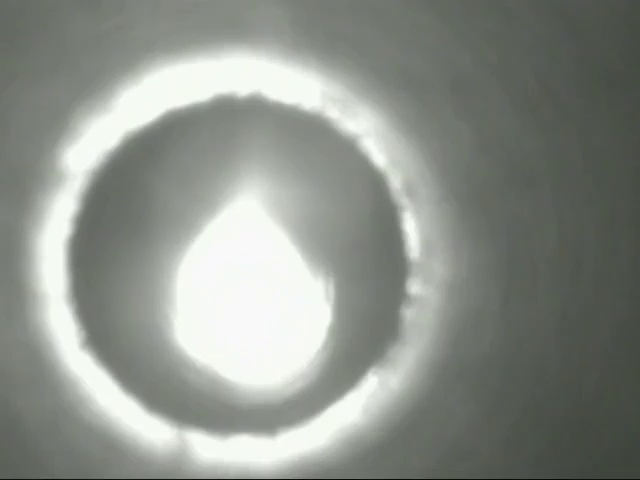

3344


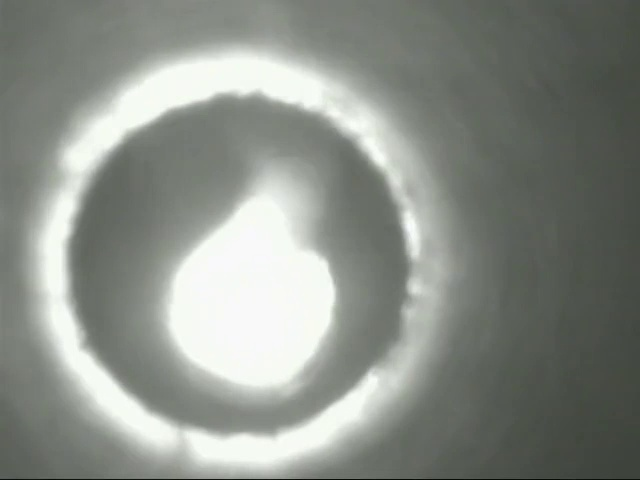

3345


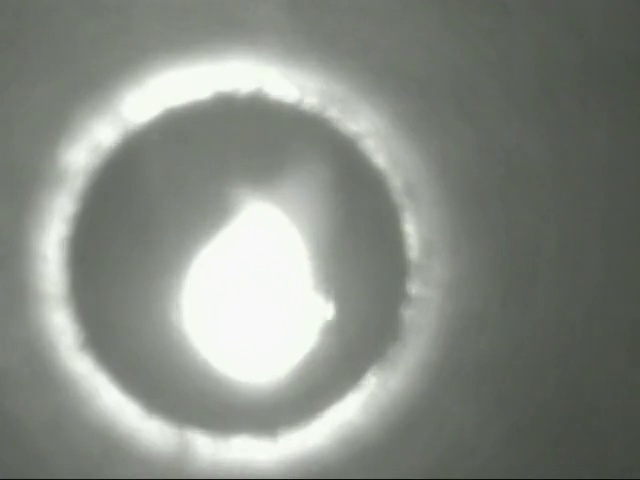

3346


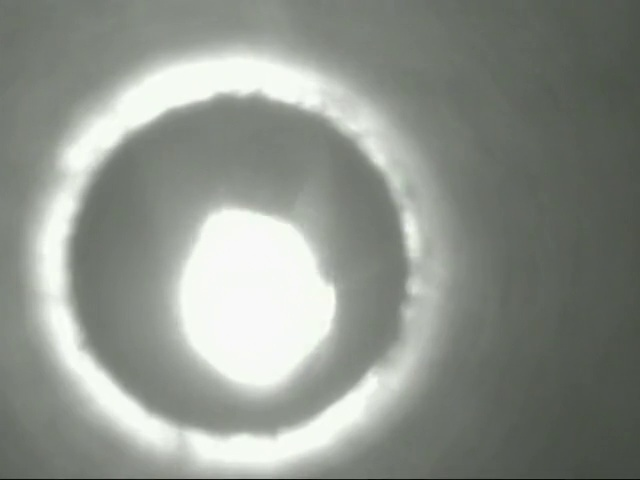

3347


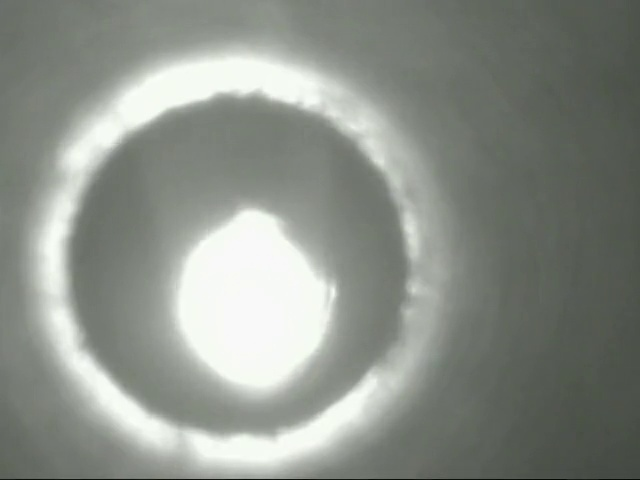

3348


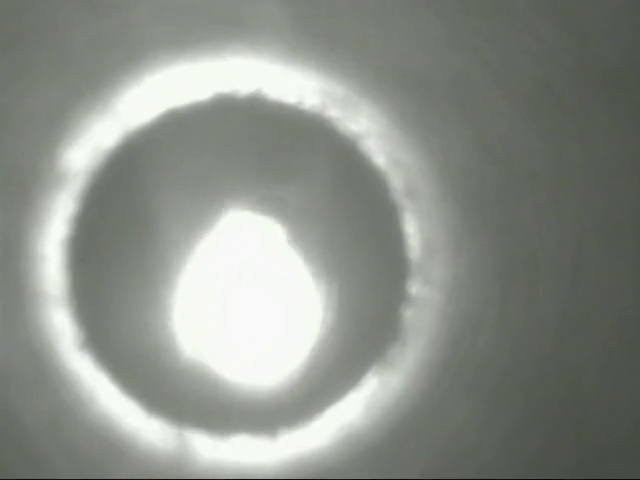

3349


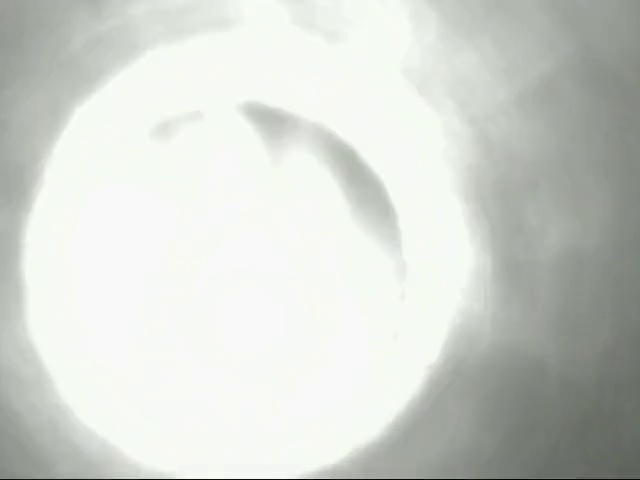

3350


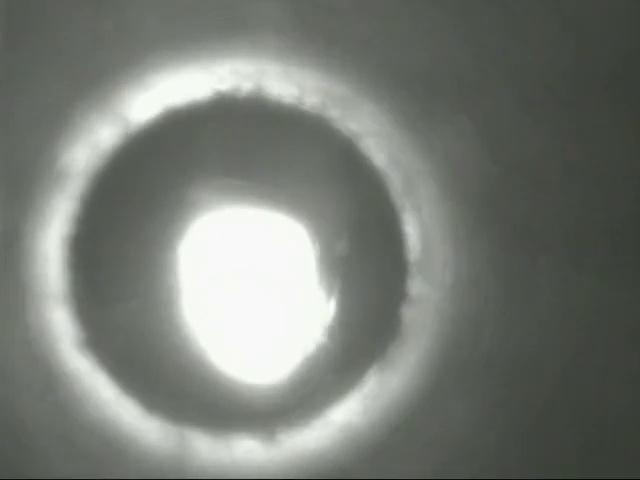

3351


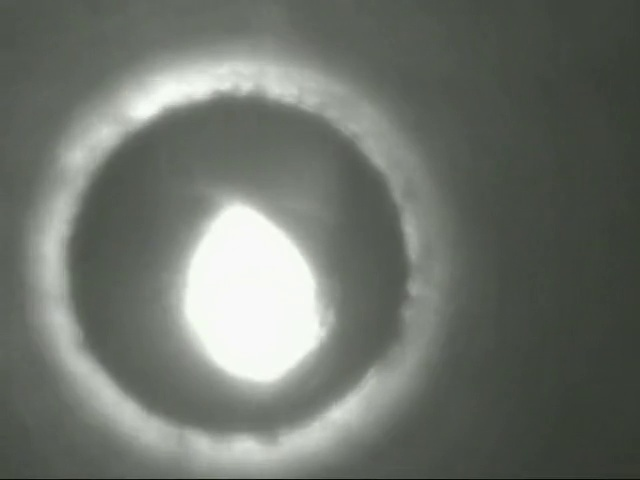

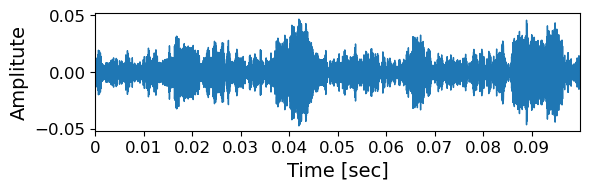

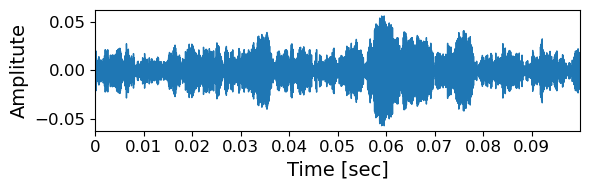

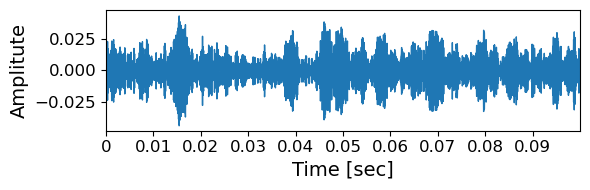

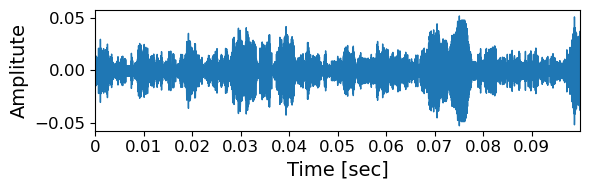

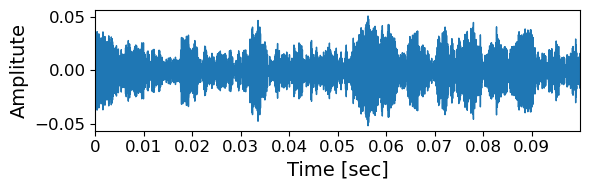

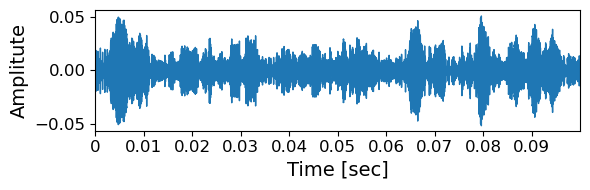

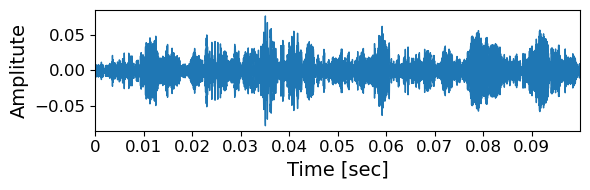

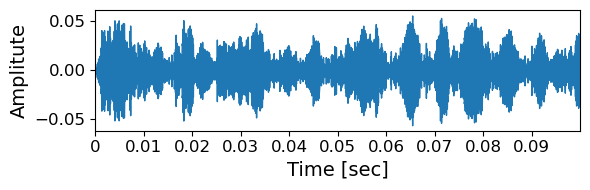

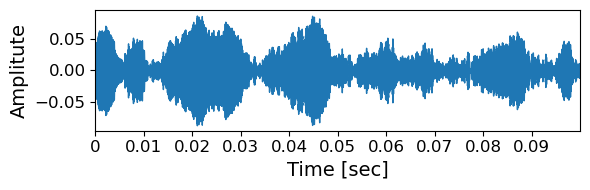

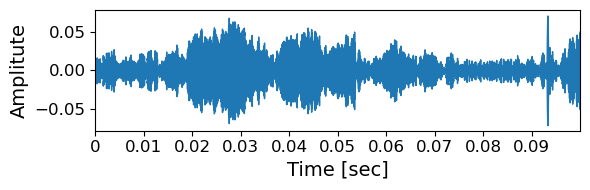

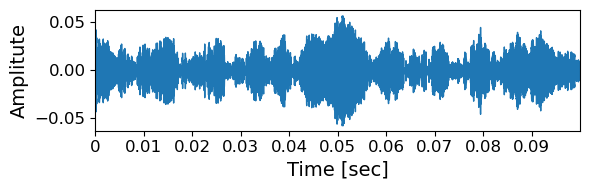

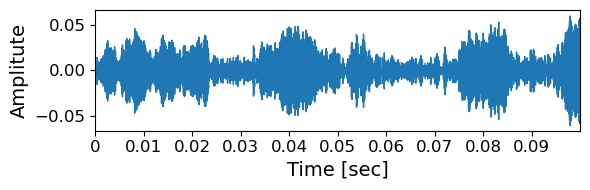

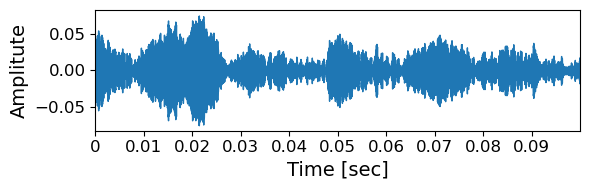

In [40]:
for i in range(3339,3352):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

In [148]:
test = []
for seg in exp_22_raw_seg[100:125]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)

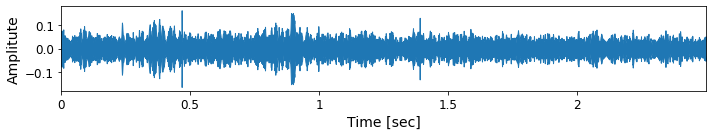

In [149]:
simple_visualization(test)

In [150]:
ipd.Audio(test, rate=sr)

In [40]:
for i in range(108,115):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_22_{i}_raw' +".wav"), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_22_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (12,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

108


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset\\Video\\segmented\\raw_audio\\sample_22_108_raw.wav'

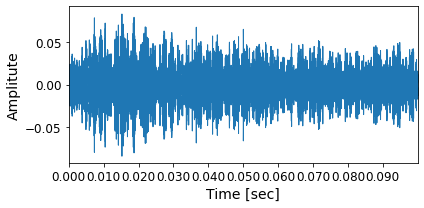

In [88]:
simple_visualization(segment_audio, fig_size = (6,3)) #int(44100*833)

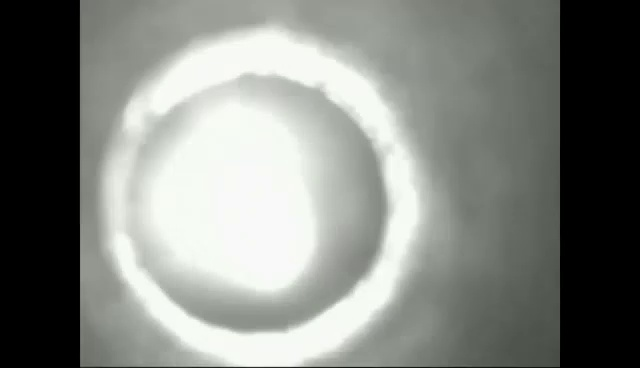

In [89]:
display(Image(segment_image, width=100))